### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import warnings


In [2]:
atac_data_df = pd.read_csv('../../data/embryo/raw/atac_peak_matrix_complete_sparse.csv', index_col=0)


In [3]:
rna_data = pl.read_csv("../../data/embryo/raw/scRNA_countMatrix.csv", ignore_errors=True)
rna_data.head()


shape: (5, 68_854)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│          ┆ 10h-1_CEL ┆ 10h-1_CEL ┆ 10h-1_CEL ┆ … ┆ 6h_3 CELL ┆ 6h_3 CELL ┆ 6h_3 CELL ┆ 6h_3 CELL │
│ ---      ┆ L1140_N1_ ┆ L1447_N1_ ┆ L1347_N1_ ┆   ┆ 4434_N1 _ ┆ 5403_N1 _ ┆ 5489_N1 _ ┆ 5447_N1 _ │
│ str      ┆ 10h-1     ┆ 10h-1     ┆ 10h-1     ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64       │
│          ┆ i64       ┆ i64       ┆ i64       ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ rpl13a   ┆ 46        ┆ 22        ┆ 27        ┆ … ┆ 3         ┆ 7         ┆ 1         ┆ 1         │
│ khdrbs1a ┆ 81        ┆ 59        ┆ 36        ┆ … ┆ 34        ┆ 23        ┆ 27        ┆ 51        │
│ apoeb    ┆ 97        ┆ 116       ┆ 193       ┆ … ┆ 19        ┆ 4         ┆ 2         ┆ 1         │
│ cfl1     ┆ 11        ┆ 9         ┆ 10        ┆ … ┆ 8         ┆ 5         ┆ 3         ┆ 6         │
│ polr2d   ┆ 5         ┆ 1         ┆ 1         ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 3         │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [4]:
# Convert to dictionary first, then to pandas
data_dict = rna_data.to_dict(as_series=False)
rna_data_df = pd.DataFrame(data_dict)
# make 1st colun the index 
rna_data_df.set_index(rna_data_df.columns[0], inplace=True)
rna_data_df


10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                                46.0                     22.0   
khdrbs1a                              81.0                     59.0   
apoeb                                 97.0                    116.0   
cfl1                                  11.0                      9.0   
polr2d                                 5.0                      1.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                                27.0                     18.0   
khdrbs1a                              36.0                     60.0   
apoeb                                193.0                     25.0   
cfl1                                  10.0                     21.0   
polr2d                                 1.0                      6.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                              73.0                    74.0   
khdrbs1a                           156.0                   165.0   
apoeb                               26.0                   565.0   
cfl1                                30.0                    37.0   
polr2d                               3.0                     3.0   
...                                  ...                     ...   
CU570797.5                           0.0                     0.0   
trgv5                                0.0                     0.0   
BX950188.3                           0.0                     0.0   
BX548038.2                           0.0                     0.0   
si:ch1073-394i4.1                    0.0                     0.0   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                               90.0                    96.0   
khdrbs1a                            184.0                   193.0   
apoeb                                93.0                    46.0   
cfl1                                 48.0                    65.0   
polr2d                                5.0                     6.0   
...                                   ...                     ...   
CU570797.5                            0.0                     0.0   
trgv5                                 0.0                     0.0   
BX950188.3                            0.0                     0.0   
BX548038.2                            0.0                     0.0   
si:ch1073-394i4.1                     0.0                     0.0   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                               58.0                    53.0  ...   
khdrbs1a                            118.0                   149.0  ...   
apoeb                                94.0                   141.0  ...   
cfl1              

In [5]:
# Load RNA data - remove empty rows and columns and set gene names as index
rna_data_df[rna_data_df.isna().any(axis=1)]

rna_data_df.dropna(axis=0, how='any', inplace=True)

rna_data_df 



10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                                46.0                     22.0   
khdrbs1a                              81.0                     59.0   
apoeb                                 97.0                    116.0   
cfl1                                  11.0                      9.0   
polr2d                                 5.0                      1.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                                27.0                     18.0   
khdrbs1a                              36.0                     60.0   
apoeb                                193.0                     25.0   
cfl1                                  10.0                     21.0   
polr2d                                 1.0                      6.0   
...                                    ...                      ...   
CU570797.5                             0.0                      0.0   
trgv5                                  0.0                      0.0   
BX950188.3                             0.0                      0.0   
BX548038.2                             0.0                      0.0   
si:ch1073-394i4.1                      0.0                      0.0   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                              73.0                    74.0   
khdrbs1a                           156.0                   165.0   
apoeb                               26.0                   565.0   
cfl1                                30.0                    37.0   
polr2d                               3.0                     3.0   
...                                  ...                     ...   
CU570797.5                           0.0                     0.0   
trgv5                                0.0                     0.0   
BX950188.3                           0.0                     0.0   
BX548038.2                           0.0                     0.0   
si:ch1073-394i4.1                    0.0                     0.0   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                               90.0                    96.0   
khdrbs1a                            184.0                   193.0   
apoeb                                93.0                    46.0   
cfl1                                 48.0                    65.0   
polr2d                                5.0                     6.0   
...                                   ...                     ...   
CU570797.5                            0.0                     0.0   
trgv5                                 0.0                     0.0   
BX950188.3                            0.0                     0.0   
BX548038.2                            0.0                     0.0   
si:ch1073-394i4.1                     0.0                     0.0   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                               58.0                    53.0  ...   
khdrbs1a                            118.0                   149.0  ...   
apoeb                                94.0                   141.0  ...   
cfl1              

In [6]:
# transform rna data - log2(x+1) for downstream steps
rna_data_log = rna_data_df.copy()
rna_data_log.iloc[:, 0:] = np.log2(rna_data_log.iloc[:, 0:].astype(float) + 1)
rna_data_log

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                            5.554589                 4.523562   
khdrbs1a                          6.357552                 5.906891   
apoeb                             6.614710                 6.870365   
cfl1                              3.584963                 3.321928   
polr2d                            2.584963                 1.000000   
...                                    ...                      ...   
CU570797.5                        0.000000                 0.000000   
trgv5                             0.000000                 0.000000   
BX950188.3                        0.000000                 0.000000   
BX548038.2                        0.000000                 0.000000   
si:ch1073-394i4.1                 0.000000                 0.000000   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                            4.807355                 4.247928   
khdrbs1a                          5.209453                 5.930737   
apoeb                             7.599913                 4.700440   
cfl1                              3.459432                 4.459432   
polr2d                            1.000000                 2.807355   
...                                    ...                      ...   
CU570797.5                        0.000000                 0.000000   
trgv5                             0.000000                 0.000000   
BX950188.3                        0.000000                 0.000000   
BX548038.2                        0.000000                 0.000000   
si:ch1073-394i4.1                 0.000000                 0.000000   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                          6.209453                6.228819   
khdrbs1a                        7.294621                7.375039   
apoeb                           4.754888                9.144658   
cfl1                            4.954196                5.247928   
polr2d                          2.000000                2.000000   
...                                  ...                     ...   
CU570797.5                      0.000000                0.000000   
trgv5                           0.000000                0.000000   
BX950188.3                      0.000000                0.000000   
BX548038.2                      0.000000                0.000000   
si:ch1073-394i4.1               0.000000                0.000000   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                           6.507795                6.599913   
khdrbs1a                         7.531381                7.599913   
apoeb                            6.554589                5.554589   
cfl1                             5.614710                6.044394   
polr2d                           2.584963                2.807355   
...                                   ...                     ...   
CU570797.5                       0.000000                0.000000   
trgv5                            0.000000                0.000000   
BX950188.3                       0.000000                0.000000   
BX548038.2                       0.000000                0.000000   
si:ch1073-394i4.1                0.000000                0.000000   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                           5.882643                5.754888  ...   
khdrbs1a                         6.894818                7.228819  ...   
apoeb                            6.569856                7.149747  ...   
cfl1              

In [7]:
rna_metadata_df = pd.read_csv('../../data/embryo/raw/rna_all.metaData.txt')
rna_metadata_df.rename(columns = {'Unnamed: 0': 'rna_cell'}, inplace=True)
rna_metadata_df

rna_cell orig.ident  nCount_RNA  nFeature_RNA  \
0      10h-1_CELL1140_N1_10h-1      10h-1       16009          3354   
1      10h-1_CELL1447_N1_10h-1      10h-1       11259          2505   
2      10h-1_CELL1347_N1_10h-1      10h-1       12532          2806   
3      10h-1_CELL1204_N1_10h-1      10h-1       14432          3312   
4        10h-1_CELL97_N2_10h-1      10h-1       31455          4443   
...                        ...        ...         ...           ...   
68848       6h_3 CELL5349_N1 _     6hpf_3        2708          1097   
68849       6h_3 CELL4434_N1 _     6hpf_3        3852          1492   
68850       6h_3 CELL5403_N1 _     6hpf_3        2694          1098   
68851       6h_3 CELL5489_N1 _     6hpf_3        2602           972   
68852       6h_3 CELL5447_N1 _     6hpf_3        2626          1097   

       percent.mt  seurat_clusters  stage               celltype  
0        1.467924               14  10hpf   anterior neural keel  
1        1.367795                3  10hpf     neurogenic placode  
2        1.324609               22  10hpf        epithelial Cell  
3        1.489745                8  10hpf               tail bud  
4        1.176284                2  10hpf  posterior neural keel  
...           ...              ...    ...                    ...  
68848    1.289134                1   6hpf               epiblast  
68849    1.011936                1   6hpf               epiblast  
68850    0.667904                1   6hpf               epiblast  
68851    1.345119                1   6hpf               epiblast  
68852    0.837776                1   6hpf               epiblast  

[68853 rows x 8 columns]

In [8]:
atac_metadata_df = pd.read_csv('../../data/embryo/raw/atac_all.metaData.txt', index_col=0)
atac_metadata_df = atac_metadata_df[['celltype', 'predictedCell', 'predictedGroup'] ]
atac_metadata_df.rename(columns = {'celltype': 'atac_cell_type', 'predictedCell': 'rna_matching_cell', 'predictedGroup': 'rna_cell_type'}, inplace=True)
atac_metadata_df.reset_index(names = "atac_cell", inplace=True)
atac_metadata_df.head()


atac_cell atac_cell_type    rna_matching_cell  \
0  3hpf_1#3hpf_1_merge_BC0443_N27     blastomere   6h_3 CELL4645_N1 _   
1  3hpf_1#3hpf_1_merge_BC0069_N07     blastomere  3h1_CELL1337_N1_3h1   
2  3hpf_1#3hpf_1_merge_BC0033_N05     blastomere  3h1_CELL1337_N1_3h1   
3  3hpf_1#3hpf_1_merge_BC0028_N08     blastomere  3h1_CELL1197_N1_3h1   
4  3hpf_1#3hpf_1_merge_BC0264_N08     blastomere  3h1_CELL1197_N1_3h1   

  rna_cell_type  
0        margin  
1    blastomere  
2    blastomere  
3    blastomere  
4    blastomere

In [9]:
celltype_lookup = dict(zip(atac_metadata_df['atac_cell'], atac_metadata_df['atac_cell_type'])) # map the cell types to the atac_cell names
atac_data_df['stage'] = atac_data_df['Cell'].str.extract(r'(\d{1,2})[a-zA-Z]', expand=False)
atac_data_df['celltype'] = atac_data_df['Cell'].map(celltype_lookup)
atac_data_df
atac_data_df['stage_celltype'] = atac_data_df['stage'] + '_' + atac_data_df['celltype']
atac_stage_counts = atac_data_df.groupby('stage')['Cell'].nunique()
atac_celltype_counts = atac_data_df.groupby('celltype')['Cell'].nunique()


In [10]:
print("shape of atac_data_df:", atac_data_df.shape)
atac_data_df.head()


shape of atac_data_df: (244265812, 5)


Cell  Accessibility stage celltype  \
Peak                                                                          
chr1:12474-12974  24hpf_1#24hpf_1_BC00224_N06              1    24      UND   
chr1:14704-15204  24hpf_1#24hpf_1_BC00224_N06              1    24      UND   
chr1:16672-17172  24hpf_1#24hpf_1_BC00224_N06              3    24      UND   
chr1:18404-18904  24hpf_1#24hpf_1_BC00224_N06              3    24      UND   
chr1:19206-19706  24hpf_1#24hpf_1_BC00224_N06              2    24      UND   

                 stage_celltype  
Peak                             
chr1:12474-12974         24_UND  
chr1:14704-15204         24_UND  
chr1:16672-17172         24_UND  
chr1:18404-18904         24_UND  
chr1:19206-19706         24_UND

In [11]:
# create mean dataframe
atac_mean_psd  = atac_data_df.pivot_table(index='Peak', 
    columns='stage_celltype', values='Accessibility', aggfunc='mean')

# Create std dataframe
atac_std_psd = atac_data_df.pivot_table(index='Peak', 
    columns='stage_celltype', values='Accessibility', aggfunc='std')


In [12]:
atac_mean_psd

stage_celltype           10_UND    10_YSL  10_anterior/posterior axis  \
Peak                                                                    
chr10:10002124-10002624     2.0  2.000000                    1.800000   
chr10:10003707-10004207     1.0       NaN                    2.000000   
chr10:10004747-10005247     2.0       NaN                    1.750000   
chr10:10008047-10008547     2.0       NaN                    2.060606   
chr10:10009662-10010162     NaN       NaN                    1.800000   
...                         ...       ...                         ...   
chr9:998557-999057          NaN  1.000000                    2.000000   
chr9:9989556-9990056        2.0  1.958333                    1.500000   
chr9:9992990-9993490        2.0  1.333333                    1.000000   
chr9:9997607-9998107        1.5  2.461538                    1.333333   
chr9:9998460-9998960        NaN  2.000000                    1.000000   

stage_celltype           10_lateral plate mesoderm  10_mesenchyme cell  \
Peak                                                                     
chr10:10002124-10002624                   2.000000                 NaN   
chr10:10003707-10004207                        NaN                 NaN   
chr10:10004747-10005247                   2.333333                 NaN   
chr10:10008047-10008547                   2.250000                 NaN   
chr10:10009662-10010162                        NaN                 NaN   
...                                            ...                 ...   
chr9:998557-999057                        1.000000                 NaN   
chr9:9989556-9990056                      2.000000                 NaN   
chr9:9992990-9993490                      2.000000                 NaN   
chr9:9997607-9998107                      1.000000                 NaN   
chr9:9998460-9998960                      2.000000                 NaN   

stage_celltype           10_neural crest  10_neural keel  \
Peak                                                       
chr10:10002124-10002624         2.000000        2.166667   
chr10:10003707-10004207         2.000000        1.888889   
chr10:10004747-10005247         2.285714        2.153846   
chr10:10008047-10008547         2.200000        2.116279   
chr10:10009662-10010162         1.750000        2.000000   
...                                  ...             ...   
chr9:998557-999057              1.500000        2.000000   
chr9:9989556-9990056            1.500000        2.750000   
chr9:9992990-9993490                 NaN        1.000000   
chr9:9997607-9998107                 NaN        2.333333   
chr9:9998460-9998960            2.000000        1.666667   

stage_celltype           10_periderm/epidermis  10_segmental plate  12_UND  \
Peak                                                                         
chr10:10002124-10002624               4.000000            2.000000     NaN   
chr10:10003707-10004207                    NaN            1.666667     NaN   
chr10:10004747-10005247               1.666667            1.666667     2.0   
chr10:10008047-10008547               2.000000            2.250000     2.0   
chr10:10009662-10010162               1.500000            3.000000     NaN   
...                                        ...                 ...     ...   
chr9:998557-999057                         NaN            2.166667     NaN   
chr9:9989556-9990056                  2.000000            2.000000     NaN   
chr9:9992990-9993490                  1.000000                 NaN     NaN   
chr9:9997607-9998107                  4.000000            1.666667     1.0   
chr9:9998460-9998960                       NaN            2.000000     NaN   

stage_celltype           ...     5_EVL  5_YSL/presumptive endoderm  \
Peak                     ...                                         
chr10:10002124-10002624  ...  1.571429                    3.000000   
chr10:10003707-10004207  ...  1.545455                    3.000000   
chr10:10004

In [13]:

def extract_stage_from_cell_id(cell_id, stage_delimiter='hpf', pos=0):
    stage_parts = str(cell_id).split(stage_delimiter)
    stage = stage_parts[pos]
    stage = stage.replace('h', '')
    return stage

atac_metadata_df['rna_stage'] = atac_metadata_df['rna_matching_cell'].apply(lambda x: extract_stage_from_cell_id(x, 'h', 0))
atac_metadata_df['atac_stage'] = atac_metadata_df['atac_cell'].apply(lambda x: extract_stage_from_cell_id(x, 'hpf', 0))
atac_metadata_df['pseudobulk'] = atac_metadata_df['atac_stage'].astype(str) + '_' + atac_metadata_df['atac_cell_type']
atac_metadata_df.head( )

atac_cell atac_cell_type    rna_matching_cell  \
0  3hpf_1#3hpf_1_merge_BC0443_N27     blastomere   6h_3 CELL4645_N1 _   
1  3hpf_1#3hpf_1_merge_BC0069_N07     blastomere  3h1_CELL1337_N1_3h1   
2  3hpf_1#3hpf_1_merge_BC0033_N05     blastomere  3h1_CELL1337_N1_3h1   
3  3hpf_1#3hpf_1_merge_BC0028_N08     blastomere  3h1_CELL1197_N1_3h1   
4  3hpf_1#3hpf_1_merge_BC0264_N08     blastomere  3h1_CELL1197_N1_3h1   

  rna_cell_type rna_stage atac_stage    pseudobulk  
0        margin         6          3  3_blastomere  
1    blastomere         3          3  3_blastomere  
2    blastomere         3          3  3_blastomere  
3    blastomere         3          3  3_blastomere  
4    blastomere         3          3  3_blastomere

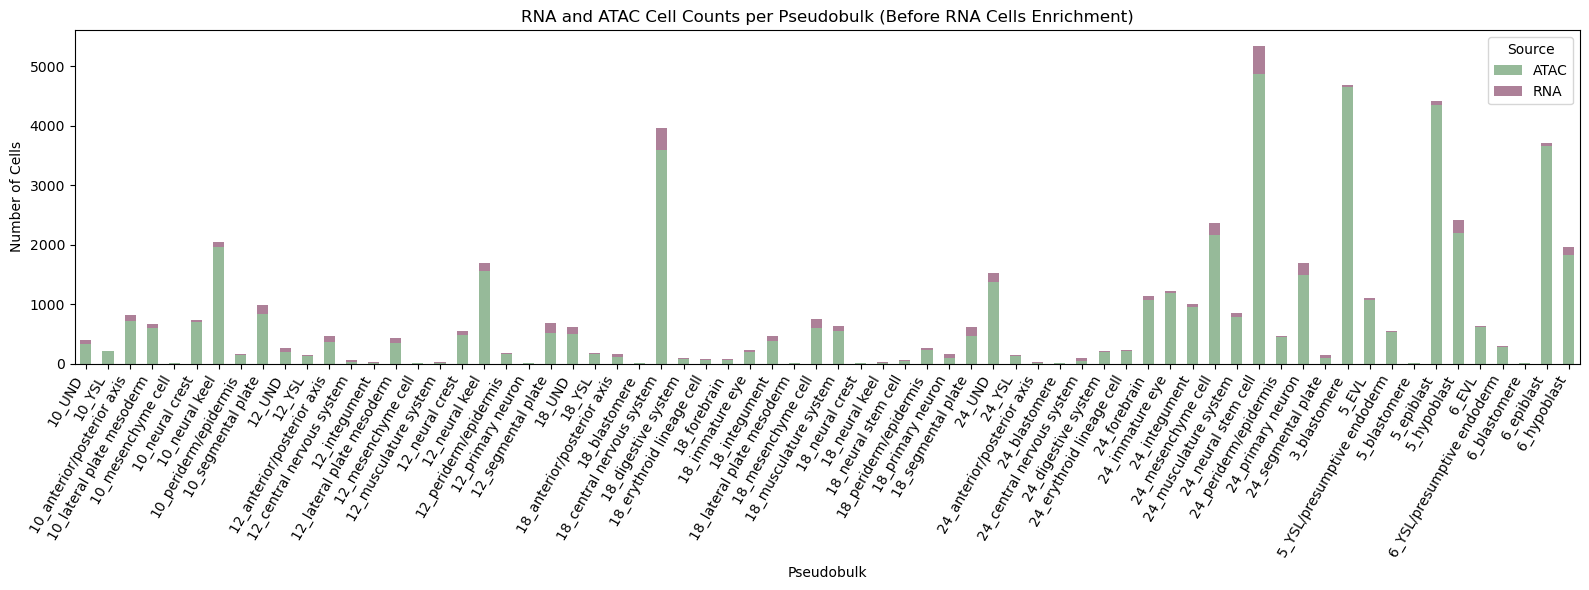

In [14]:
atac_counts = atac_metadata_df.groupby('pseudobulk')['atac_cell'].nunique().reset_index(name='ATAC')
rna_counts = atac_metadata_df.groupby('pseudobulk')['rna_matching_cell'].nunique().reset_index(name='RNA')

stacked_counts = pd.merge(atac_counts, rna_counts, on='pseudobulk', how='outer').fillna(0)
stacked_counts[['ATAC', 'RNA']] = stacked_counts[['ATAC', 'RNA']].astype(int)

stacked_counts.set_index('pseudobulk')[['ATAC', 'RNA']].plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    color=['#96ba99', '#ad8098']
)

plt.xticks(rotation=60, ha='right')
plt.xlabel('Pseudobulk')
plt.ylabel('Number of Cells')
plt.title('RNA and ATAC Cell Counts per Pseudobulk (Before RNA Cells Enrichment)')
plt.legend(title='Source')
plt.tight_layout()
plt.show()



#### Only 2258 RNA cells are assigned to ATAC cells

In [36]:
# filter rna_data_log to only keep the rows with max  value >=4
rna_data_log_filter_low_genes = rna_data_log[rna_data_log.max(axis=1) >= 4]
rna_data_log_filter_low_genes

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   
...                         ...                     ...   
tmc2a                  0.000000                0.000000   
gnb3a                  0.000000                0.000000   
cd164l2                0.000000                0.000000   
cpa5                   0.000000                0.000000   
dharma                 0.000000                0.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   
...                          ...                     ...  ...   
tmc2a                   0.000000                0.000000  ...   
gnb3a                   0.000000                0.000000  ...   
cd164l2                 0.000000                0.000000  ...   
cpa5                    0.000000                0.000000  ...   
dharma                  0.000000                0.000000  ...   

 

In [39]:
# continue with log values
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_data_matched_filter_low_genes = rna_data_log_filter_low_genes.loc[:, rna_data_log_filter_low_genes.columns.intersection(matching_cells)]
rna_data_unmatched_filter_low_genes = rna_data_log_filter_low_genes.loc[:, ~rna_data_log_filter_low_genes.columns.isin(matching_cells)]
rna_data_unmatched_filter_low_genes

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   
...                         ...                     ...   
tmc2a                  0.000000                0.000000   
gnb3a                  0.000000                0.000000   
cd164l2                0.000000                0.000000   
cpa5                   0.000000                0.000000   
dharma                 0.000000                0.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   
...                          ...                     ...  ...   
tmc2a                   0.000000                0.000000  ...   
gnb3a                   0.000000                0.000000  ...   
cd164l2                 0.000000                0.000000  ...   
cpa5                    0.000000                0.000000  ...   
dharma                  0.000000                0.000000  ...   

 

In [43]:
rna_data_matched_filter_low_genes

10h-1_CELL122_N2_10h-1  10h-1_CELL338_N1_10h-1  \
                                                           
rpl13a                  7.000000                5.930737   
khdrbs1a                7.864186                7.417853   
apoeb                   6.442943                8.179909   
cfl1                    5.977280                5.169925   
polr2d                  3.000000                2.000000   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL789_N1_10h-1  10h-1_CELL32_N2_10h-1  \
                                                          
rpl13a                  5.285402               5.700440   
khdrbs1a                6.845490               6.584963   
apoeb                   5.426265               6.459432   
cfl1                    4.247928               4.643856   
polr2d                  2.584963               2.321928   
...                          ...                    ...   
tmc2a                   0.000000               0.000000   
gnb3a                   0.000000               0.000000   
cd164l2                 0.000000               0.000000   
cpa5                    0.000000               0.000000   
dharma                  0.000000               0.000000   

          10h-1_CELL240_N1_10h-1  10h-1_CELL198_N1_10h-1  \
                                                           
rpl13a                  6.643856                7.066089   
khdrbs1a                7.707359                8.113742   
apoeb                   5.321928                8.174926   
cfl1                    6.149747                5.930737   
polr2d                  2.000000                4.087463   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL183_N1_10h-1  10h-1_CELL794_N1_10h-1  \
                                                           
rpl13a                  6.475733                5.491853   
khdrbs1a                6.149747                7.179909   
apoeb                   5.700440                6.357552   
cfl1                    4.857981                4.169925   
polr2d                  2.321928                2.321928   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL275_N1_10h-1  10h-1_CELL1288_N1_10h-1  ...  \
                                                           ...   
rpl13a                  6.614710                 4.754888  ...   
khdrbs1a                6.569856                 6.491853  ...   
apoeb                   4.523562                 4.700440  ...   
cfl1                    4.754888                 3.906891  ...   
polr2d                  1.584963                 2.321928  ...   
...                          ...                      ...  ...   
tmc2a                   0.000000                 0.000000  ...   
gnb3a                   0.000000                 0.000000  ...   
cd164l2                 0.000000                 0.000000  ...   
cpa5                    0.000000                 0.000000  ...   
dharma                  0.000000                 0.000000  ...   

          6h_3 CELL2532_N1 _  6h_3 CELL4

##### Define a cutoff for each pseudobulk as the distance between this (mean vector of same psd cells) and the most distant cell of the same celltype (from any time point).
##### Compute the distance from same cell type cells to each pseudobulk considering only genes with max log expression >=4
    - To enrich the pseudobulks with unmatched RNA cells we will use this cutoff
    - If a new cell has a distance > cutoff, it is more different than any cell of that type used to define the pseudobulk 

In [ ]:
from scipy.spatial.distance import cdist

def compute_pseudobulk_cutoffs_df(rna_data_matched, atac_metadata):
    metadata = atac_metadata.set_index('rna_matching_cell').loc[rna_data_matched.columns].reset_index(names='rna_matching_cell')
    pseudobulk_means = {
        pb: rna_data_matched[metadata[metadata['pseudobulk'] == pb]['rna_matching_cell']].mean(axis=1)
        for pb in metadata['pseudobulk'].unique()
    }

    results = []
    for pb, mean_vec in pseudobulk_means.items():
        celltype = metadata[metadata['pseudobulk'] == pb]['atac_cell_type'].iloc[0]
        same_type_cells = metadata[metadata['atac_cell_type'] == celltype]['rna_matching_cell']
        same_type_matrix = rna_data_matched[same_type_cells].T.values  # shape: (n_cells, n_genes)
        
        mean_vec_reshaped = mean_vec.values.reshape(1, -1)  # shape: (1, n_genes)
        distances = cdist(same_type_matrix, mean_vec_reshaped, metric='euclidean').flatten()  # shape: (n_cells,)
        
        results.append({
            'pseudobulk': pb,
            'atac_cell_type': celltype,
            'cutoff': distances.max(),
            'n_cells_in_pseudobulk': (metadata['pseudobulk'] == pb).sum(),
            'n_cells_same_type': (metadata['atac_cell_type'] == celltype).sum()
        })
    
    return pd.DataFrame(results)
compute_pseudobulk_cutoffs_df(rna_data_matched_filter_low_genes, atac_metadata_df)



          10h-1_CELL122_N2_10h-1  10h-1_CELL338_N1_10h-1  \
                                                           
rpl13a                  7.000000                5.930737   
khdrbs1a                7.864186                7.417853   
apoeb                   6.442943                8.179909   
cfl1                    5.977280                5.169925   
polr2d                  3.000000                2.000000   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL789_N1_10h-1  10h-1_CELL32_N2_10h-1  \
                                                          
rpl13a                  5.285402               5.700440   
khdrbs1a                6.845490          

pseudobulk          atac_cell_type      cutoff  \
0              12_neural keel             neural keel  138.797406   
1   18_central nervous system  central nervous system  173.781686   
2             10_neural crest            neural crest  118.594639   
3             12_neural crest            neural crest  117.974890   
4               12_integument              integument  125.629656   
..                        ...                     ...         ...   
63               6_blastomere              blastomere  166.153537   
64          12_primary neuron          primary neuron  167.140716   
65               5_blastomere              blastomere  159.682524   
66                      5_EVL                     EVL  106.988053   
67                      6_EVL                     EVL  112.322791   

    n_cells_in_pseudobulk  n_cells_same_type  
0                    1557               3525  
1                    3599               3672  
2                     694               1177  
3                     478               1177  
4                      10               1336  
..                    ...                ...  
63                      5               4676  
64                      1               1598  
65                      2               4676  
66                   1071               1678  
67                    607               1678  

[68 rows x 5 columns]

In [18]:
# create rna_data_pseudobulk mean and std dataframes for the log transformed data. 
# Aggregate the RNA data by pseudobulk using the matched cells "og"
cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
rna_data_psd_names = rna_data_matched.rename(columns=cell_to_pseudobulk)
rna_data_std_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
rna_data_mean_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()

rna_data_mean_pseudobulk_og


/tmp/ipykernel_3569643/4256116102.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
/tmp/ipykernel_3569643/4256116102.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()


10_UND    10_YSL  10_anterior/posterior axis  \
                                                                    
rpl13a             5.084864  2.292481                    5.977550   
khdrbs1a           4.742312  3.284928                    6.498762   
apoeb              2.446045  6.575984                    4.891290   
cfl1               3.911818  2.292481                    4.642868   
polr2d             1.181378  0.000000                    1.874917   
...                     ...       ...                         ...   
CU570797.5         0.000000  0.000000                    0.000000   
trgv5              0.000000  0.000000                    0.000000   
BX950188.3         0.000000  0.000000                    0.000000   
BX548038.2         0.000000  0.000000                    0.000000   
si:ch1073-394i4.1  0.000000  0.000000                    0.000000   

                   10_lateral plate mesoderm  10_neural crest  10_neural keel  \
                                                                                
rpl13a                              5.505295         5.860131        5.471751   
khdrbs1a                            6.354888         6.985411        6.233713   
apoeb                               4.907480         6.666729        4.654771   
cfl1                                4.655234         4.435093        4.392690   
polr2d                              1.880436         1.776963        1.805762   
...                                      ...              ...             ...   
CU570797.5                          0.000000         0.000000        0.000000   
trgv5                               0.000000         0.000000        0.000000   
BX950188.3                          0.000000         0.000000        0.000000   
BX548038.2                          0.000000         0.000000        0.000000   
si:ch1073-394i4.1                   0.000000         0.000000        0.000000   

                   10_periderm/epidermis  10_segmental plate    12_UND  \
                                                                         
rpl13a                          4.346743            5.809875  5.433258   
khdrbs1a                        2.729716            6.072204  5.686432   
apoeb                           0.000000            4.813227  3.869535   
cfl1                            0.000000            4.284868  4.602898   
polr2d                          0.000000            1.900582  1.602456   
...                                  ...                 ...       ...   
CU570797.5                      0.000000            0.000000  0.000000   
trgv5                           0.000000            0.000000  0.000000   
BX950188.3                      0.000000            0.000000  0.000000   
BX548038.2                      0.000000            0.000000  0.000000   
si:ch1073-394i4.1               0.000000            0.000000  0.000000   

                     12_YSL  ...  3_blastomere     5_EVL  \
                             ...                           
rpl13a             1.584963  ...      2.850926  4.662160   
khdrbs1a           3.700440  ...      5.354773  7.578096   
apoeb              0.000000  ...      2.321131  2.223308   
cfl1               3.000000  ...      4.364861  5.546121   
polr2d             0.000000  ...      1.321714  1.166667   
...                     ...  ...           ...       ...   
CU570797.5         0.000000  ...      0.000000  0.000000   
trgv5              0.000000  ...      0.000000  0.000000   
BX950188.3         0.000000  ...      0.000000  0.000000   
BX548038.2         0.000000  ...      0.000000  0.000000   
si:ch1073-394i4.1  0.000000  ...      0.000000  0.000000   

                   5_YSL/presumptive endoderm  5_epiblast  5_hypoblast  \
                                                                         
rpl13a                               1.935785    2.623231     3.276358   
khdrbs1a                             3.043094    6.082239     6.388591   
apoeb                        

In [20]:
rna_data_std_pseudobulk_og.head()

10_UND    10_YSL  10_anterior/posterior axis  \
                                                           
rpl13a    1.399266  0.413631                    0.691835   
khdrbs1a  1.208938  1.361887                    0.831250   
apoeb     1.736827  0.518353                    1.892713   
cfl1      1.250308  0.413631                    0.725061   
polr2d    0.933950  0.000000                    0.901121   

          10_lateral plate mesoderm  10_neural crest  10_neural keel  \
                                                                       
rpl13a                     0.979182         0.144222        0.878417   
khdrbs1a                   1.111963         0.371969        0.901576   
apoeb                      1.714878         1.156514        1.552761   
cfl1                       1.140185         0.573928        0.855007   
polr2d                     0.959408         1.404155        0.677890   

          10_periderm/epidermis  10_segmental plate    12_UND  12_YSL  ...  \
                                                                       ...   
rpl13a                 0.250059            0.862723  1.354339     NaN  ...   
khdrbs1a               1.031974            0.918636  1.330595     NaN  ...   
apoeb                  0.000000            1.724409  2.079896     NaN  ...   
cfl1                   0.000000            0.984587  1.068130     NaN  ...   
polr2d                 0.000000            1.051465  1.016213     NaN  ...   

          3_blastomere     5_EVL  5_YSL/presumptive endoderm  5_epiblast  \
                                                                           
rpl13a        1.219588  0.680301                    1.679204    0.993310   
khdrbs1a      1.099967  0.242179                    1.918932    0.906787   
apoeb         1.410240  0.975078                    0.604008    1.023677   
cfl1          1.023061  0.580672                    1.303466    0.795998   
polr2d        0.993516  0.752773                    0.000000    0.757726   

          5_hypoblast     6_EVL  6_YSL/presumptive endoderm  6_blastomere  \
                                                                            
rpl13a       1.092262  1.210776                    0.991226      0.893100   
khdrbs1a     0.839930  1.238302                    1.338324      0.620846   
apoeb        1.506551  1.145386                    1.609619      1.414214   
cfl1         1.289989  1.132852                    1.391626      0.165792   
polr2d       0.930309  0.725589                    0.462910      0.707107   

          6_epiblast  6_hypoblast  
                                   
rpl13a      1.355275     1.138125  
khdrbs1a    0.928272     0.895115  
apoeb       1.781348     1.312432  
cfl1        1.102192     1.262371  
polr2d      0.955562     0.930771  

[5 rows x 63 columns]

In [ ]:
# compute the euclidean distance of each unmatched cell to the mean of each pseudobulk considering ALL genes
def assign_cells_to_pseudobulk_all_genes(rna_data_unmatched, rna_data_mean_pseudobulk):
    # include only the genes that are present in both dataframes
    common_genes = rna_data_unmatched.index.intersection(rna_data_mean_pseudobulk.index)
    rna_data_unmatched = rna_data_unmatched.loc[common_genes]
    
    unmatched_matrix = rna_data_unmatched.T.values 
    pseudobulk_matrix = rna_data_mean_pseudobulk.T.values 
    distance_matrix = cdist(unmatched_matrix, pseudobulk_matrix, metric='euclidean')
    pseudobulk_names = list(rna_data_mean_pseudobulk.columns)
    cell_names = list(rna_data_unmatched.columns)
    closest_indices = np.argmin(distance_matrix, axis=1)
    closest_pseudobulks = [pseudobulk_names[i] for i in closest_indices]
    closest_distances = distance_matrix[np.arange(len(cell_names)), closest_indices]
    cell_to_pseudobulk = dict(zip(cell_names, closest_pseudobulks))
    cell_to_distance = dict(zip(cell_names, closest_distances))

    return cell_to_pseudobulk, cell_to_distance
cell_to_pseudobulk, cell_to_distance = assign_cells_to_pseudobulk_all_genes(rna_data_unmatched, rna_data_mean_pseudobulk_og)
cell_to_pseudobulk

{'10h-1_CELL1140_N1_10h-1': '6_epiblast',
 '10h-1_CELL1447_N1_10h-1': '6_epiblast',
 '10h-1_CELL1347_N1_10h-1': '24_UND',
 '10h-1_CELL1204_N1_10h-1': '12_anterior/posterior axis',
 '10h-1_CELL97_N2_10h-1': '12_neural keel',
 '10h-1_CELL539_N1_10h-1': '12_neural crest',
 '10h-1_CELL310_N1_10h-1': '18_neural keel',
 '10h-1_CELL311_N1_10h-1': '18_neural keel',
 '10h-1_CELL665_N1_10h-1': '10_anterior/posterior axis',
 '10h-1_CELL350_N1_10h-1': '10_neural crest',
 '10h-1_CELL434_N1_10h-1': '10_anterior/posterior axis',
 '10h-1_CELL335_N1_10h-1': '10_anterior/posterior axis',
 '10h-1_CELL1086_N1_10h-1': '12_segmental plate',
 '10h-1_CELL2213_N1_10h-1': '5_YSL/presumptive endoderm',
 '10h-1_CELL646_N1_10h-1': '10_anterior/posterior axis',
 '10h-1_CELL320_N1_10h-1': '12_neural crest',
 '10h-1_CELL149_N2_10h-1': '10_neural crest',
 '10h-1_CELL1088_N1_10h-1': '12_anterior/posterior axis',
 '10h-1_CELL712_N1_10h-1': '12_neural keel',
 '10h-1_CELL1097_N1_10h-1': '18_central nervous system',
 '10h-

Step 1: Assigning cells using all genes...

Step 2: Finding marker genes for each pseudobulk...
Finding markers for 10_UND...
Found 0 marker genes for 10_UND
Finding markers for 10_YSL...
Found 8 marker genes for 10_YSL
Finding markers for 10_anterior/posterior axis...
Found 0 marker genes for 10_anterior/posterior axis
Finding markers for 10_lateral plate mesoderm...
Found 0 marker genes for 10_lateral plate mesoderm
Finding markers for 10_neural crest...
Found 0 marker genes for 10_neural crest
Finding markers for 10_neural keel...
Found 0 marker genes for 10_neural keel
Finding markers for 10_periderm/epidermis...
Found 58 marker genes for 10_periderm/epidermis
Finding markers for 10_segmental plate...
Found 0 marker genes for 10_segmental plate
Finding markers for 12_UND...
Found 0 marker genes for 12_UND
Finding markers for 12_YSL...
Found 0 marker genes for 12_YSL
Finding markers for 12_anterior/posterior axis...
Found 0 marker genes for 12_anterior/posterior axis
Finding markers

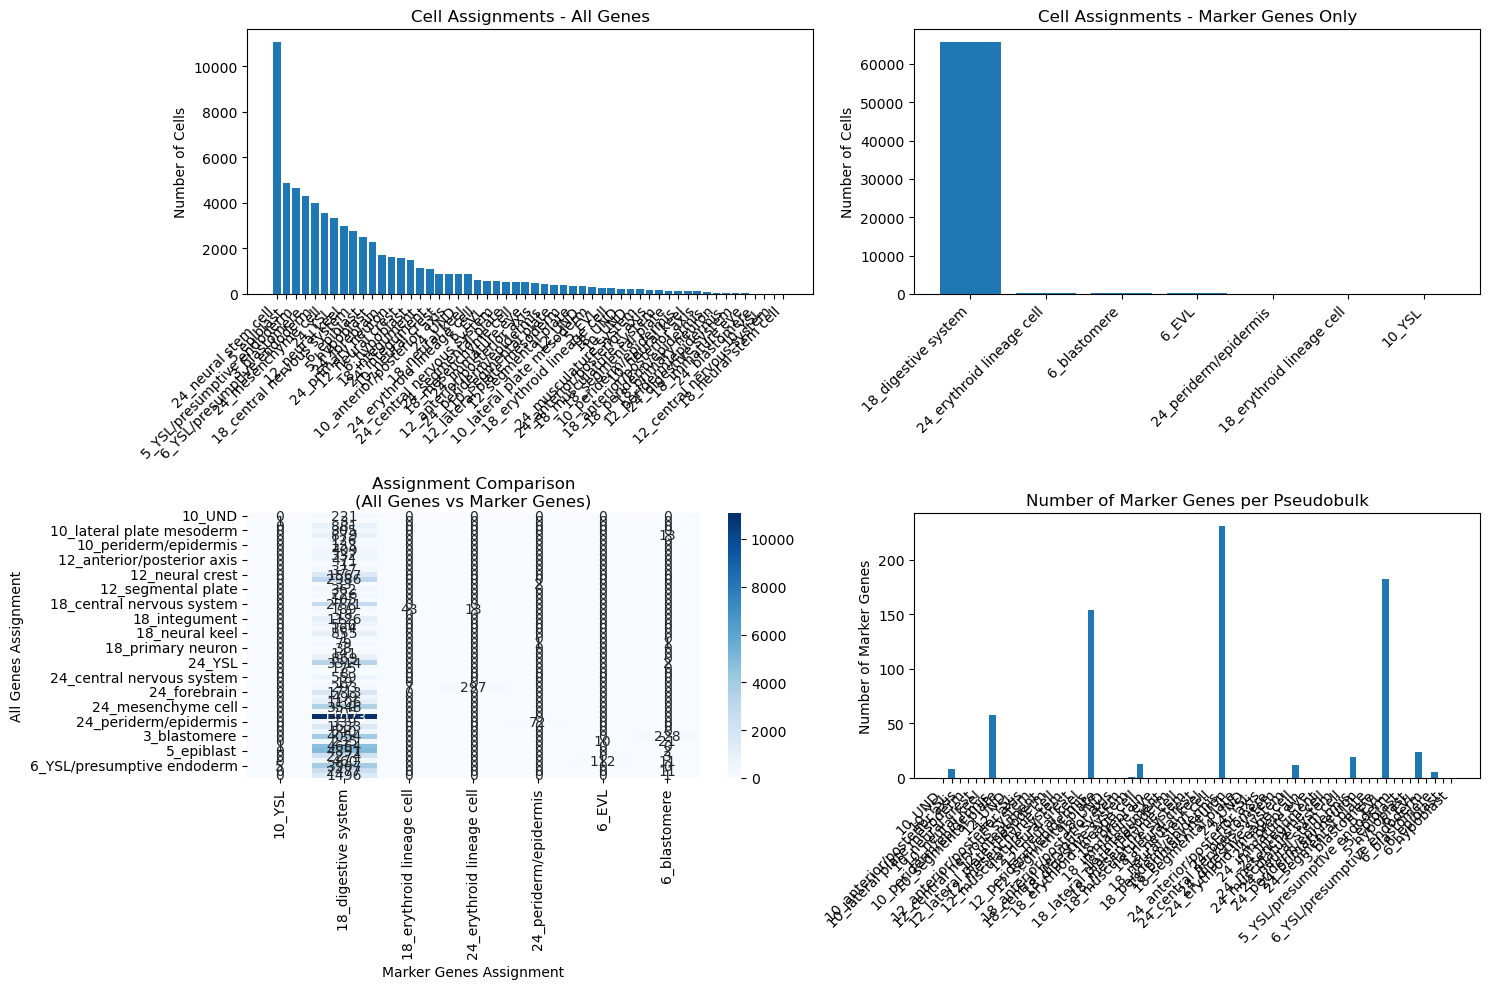


Assignment Agreement: 0.79%
Total cells assigned: 66595

Example marker genes per pseudobulk:
10_UND: []...
10_YSL: ['afp4', 'acp5a', 'npc2', 'zgc:153018', 'ctsll', 'fbp1b', 'anxa1a', 'mttp']...
10_anterior/posterior axis: []...

Saving results...
Analysis complete!
Results stored in:
- cell_to_pseudobulk_all: assignments using all genes
- cell_to_pseudobulk_markers: assignments using marker genes only
- marker_genes_dict: marker genes for each pseudobulk
- df_all_genes: detailed results for all genes method
- df_markers_only: detailed results for marker genes method


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

def assign_cells_to_pseudobulk_all_genes(rna_data_unmatched, rna_data_mean_pseudobulk):
    """
    Assign cells to pseudobulks using all genes based on euclidean distance
    """
    unmatched_matrix = rna_data_unmatched.T.values
    pseudobulk_matrix = rna_data_mean_pseudobulk.T.values
    
    # Compute euclidean distance matrix
    distance_matrix = cdist(unmatched_matrix, pseudobulk_matrix, metric='euclidean')
    
    pseudobulk_names = list(rna_data_mean_pseudobulk.columns)
    cell_names = list(rna_data_unmatched.columns)
    
    # Find closest pseudobulk for each cell
    closest_indices = np.argmin(distance_matrix, axis=1)
    closest_pseudobulks = [pseudobulk_names[i] for i in closest_indices]
    closest_distances = distance_matrix[np.arange(len(cell_names)), closest_indices]
    
    # Create assignment dictionaries
    cell_to_pseudobulk = dict(zip(cell_names, closest_pseudobulks))
    cell_to_distance = dict(zip(cell_names, closest_distances))
    
    return cell_to_pseudobulk, cell_to_distance

def find_marker_genes_per_pseudobulk(rna_data_mean_pseudobulk_og, rna_data_std_pseudobulk_og, 
                                   pvalue_threshold=0.05, log_fc_threshold=0.5):
    """
    Find marker genes for each pseudobulk using t-tests
    """
    pseudobulks = rna_data_mean_pseudobulk_og.columns.tolist()
    genes = rna_data_mean_pseudobulk_og.index.tolist()
    
    marker_genes_dict = {}
    
    for pseudobulk in pseudobulks:
        print(f"Finding markers for {pseudobulk}...")
        
        # Get mean and std for current pseudobulk
        current_mean = rna_data_mean_pseudobulk_og[pseudobulk]
        current_std = rna_data_std_pseudobulk_og[pseudobulk]
        
        # Get mean and std for all other pseudobulks
        other_pseudobulks = [p for p in pseudobulks if p != pseudobulk]
        other_means = rna_data_mean_pseudobulk_og[other_pseudobulks].mean(axis=1)
        other_stds = rna_data_std_pseudobulk_og[other_pseudobulks].mean(axis=1)
        
        # Perform t-test for each gene
        t_stats = []
        p_values = []
        log_fold_changes = []
        
        for gene in genes:
            # Calculate log fold change
            if other_means[gene] > 0:
                log_fc = np.log2((current_mean[gene] + 1e-8) / (other_means[gene] + 1e-8))
            else:
                log_fc = np.log2(current_mean[gene] + 1e-8)
            
            # Perform t-test (assuming equal variance)
            if current_std[gene] > 0 and other_stds[gene] > 0:
                # Use Welch's t-test for unequal variances
                t_stat = (current_mean[gene] - other_means[gene]) / np.sqrt(
                    (current_std[gene]**2) + (other_stds[gene]**2)
                )
                # Approximate p-value (simplified)
                p_val = 2 * (1 - stats.norm.cdf(abs(t_stat)))
            else:
                t_stat = 0
                p_val = 1.0
            
            t_stats.append(t_stat)
            p_values.append(p_val)
            log_fold_changes.append(log_fc)
        
        # Multiple testing correction
        _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')
        
        # Select marker genes
        marker_mask = (p_values_corrected < pvalue_threshold) & (np.array(log_fold_changes) > log_fc_threshold)
        marker_genes = [genes[i] for i in range(len(genes)) if marker_mask[i]]
        
        marker_genes_dict[pseudobulk] = marker_genes
        print(f"Found {len(marker_genes)} marker genes for {pseudobulk}")
    
    return marker_genes_dict

def assign_cells_to_pseudobulk_markers_only(rna_data_unmatched, rna_data_mean_pseudobulk_og, 
                                          marker_genes_dict):
    """
    Assign cells to pseudobulks using only marker genes for each pseudobulk
    """
    cell_names = list(rna_data_unmatched.columns)
    pseudobulk_names = list(rna_data_mean_pseudobulk_og.columns)
    
    # For each cell, compute distance to each pseudobulk using only that pseudobulk's markers
    cell_assignments = {}
    cell_distances = {}
    
    for cell in cell_names:
        min_distance = float('inf')
        best_pseudobulk = None
        distances_to_pseudobulks = {}
        
        for pseudobulk in pseudobulk_names:
            marker_genes = marker_genes_dict[pseudobulk]
            
            if len(marker_genes) == 0:
                # If no markers, use very high distance
                distance = float('inf')
            else:
                # Get expression values for marker genes only
                cell_expression = rna_data_unmatched.loc[marker_genes, cell].values
                pseudobulk_expression = rna_data_mean_pseudobulk_og.loc[marker_genes, pseudobulk].values
                
                # Compute euclidean distance
                distance = np.sqrt(np.sum((cell_expression - pseudobulk_expression)**2))
            
            distances_to_pseudobulks[pseudobulk] = distance
            
            if distance < min_distance:
                min_distance = distance
                best_pseudobulk = pseudobulk
        
        cell_assignments[cell] = best_pseudobulk
        cell_distances[cell] = min_distance
    
    return cell_assignments, cell_distances


In [192]:
cell_to_celltype = atac_metadata_df.set_index('rna_matching_cell')['atac_cell_type'].to_dict()
rna_data_celltype_named = rna_data_matched.rename(columns=cell_to_celltype)
rna_data_mean_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).mean()
rna_data_std_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).std()
rna_data_mean_celltype


/tmp/ipykernel_3381107/3246719885.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).mean()
/tmp/ipykernel_3381107/3246719885.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).std()


EVL       UND       YSL  YSL/presumptive endoderm  \
                                                                            
rpl13a             4.285865  5.373029  2.145203                  1.914009   
khdrbs1a           7.091245  4.641468  3.531996                  3.754512   
apoeb              1.576994  2.243638  2.475344                  5.692448   
cfl1               4.956887  4.316922  3.133526                  2.318557   
polr2d             0.792308  1.218737  0.325906                  0.181818   
...                     ...       ...       ...                       ...   
CU570797.5         0.000000  0.000000  0.000000                  0.000000   
trgv5              0.000000  0.000000  0.000000                  0.000000   
BX950188.3         0.000000  0.000000  0.000000                  0.000000   
BX548038.2         0.000000  0.000000  0.000000                  0.000000   
si:ch1073-394i4.1  0.000000  0.000000  0.000000                  0.000000   

                   anterior/posterior axis  blastomere  \
                                                         
rpl13a                            5.823040    2.956376   
khdrbs1a                          6.192894    5.289375   
apoeb                             4.387039    2.445933   
cfl1                              4.630494    4.180602   
polr2d                            1.794301    1.273457   
...                                    ...         ...   
CU570797.5                        0.000000    0.000000   
trgv5                             0.000000    0.000000   
BX950188.3                        0.000000    0.000000   
BX548038.2                        0.000000    0.000000   
si:ch1073-394i4.1                 0.000000    0.000000   

                   central nervous system  digestive system  epiblast  \
                                                                        
rpl13a                           5.530406          5.511907  3.900449   
khdrbs1a                         5.399760          4.998037  6.401890   
apoeb                            2.898172          2.825049  5.414615   
cfl1                             4.154317          4.261396  3.827576   
polr2d                           1.676043          0.966178  1.421633   
...                                   ...               ...       ...   
CU570797.5                       0.000000          0.000000  0.000000   
trgv5                            0.000000          0.000000  0.000000   
BX950188.3                       0.000000          0.000000  0.000000   
BX548038.2                       0.000000          0.000000  0.000000   
si:ch1073-394i4.1                0.000000          0.000000  0.000000   

                   erythroid lineage cell  ...  integument  \
                                           ...               
rpl13a                           5.977981  ...    5.279508   
khdrbs1a                         3.778627  ...    3.804133   
apoeb                            0.935194  ...    5.308447   
cfl1                             3.566287  ...    2.456101   
polr2d                           0.714283  ...    0.982613   
...                                   ...  ...         ...   
CU570797.5                       0.000000  ...    0.000000   
trgv5                            0.000000  ...    0.000000   
BX950188.3                       0.000000  ...    0.000000   
BX548038.2                       0.000000  ...    0.000000   
si:ch1073-394i4.1                0.000000  ...    0.000000   

                   lateral plate mesoderm  mesenchyme cell  \
                                                             
rpl13a                           5.424183         5.103153   
khdrbs1a                         6.003210         4.503269   
apoeb                            4.211091         1.651637   
cfl1                             4.508843         4.087893   
polr2d                           1.726063         1.146742   
...                                   ...              ...   
CU570797.5    

In [195]:
rna_data_std_celltype

EVL       UND       YSL  YSL/presumptive endoderm  \
                                                                            
rpl13a             1.121914  1.293915  1.081346                  1.118888   
khdrbs1a           1.123004  1.526927  1.510844                  1.482906   
apoeb              1.147146  2.067198  2.670112                  1.425495   
cfl1               1.074733  1.464695  1.350151                  1.304507   
polr2d             0.745346  1.055721  0.578251                  0.404520   
...                     ...       ...       ...                       ...   
CU570797.5         0.000000  0.000000  0.000000                  0.000000   
trgv5              0.000000  0.000000  0.000000                  0.000000   
BX950188.3         0.000000  0.000000  0.000000                  0.000000   
BX548038.2         0.000000  0.000000  0.000000                  0.000000   
si:ch1073-394i4.1  0.000000  0.000000  0.000000                  0.000000   

                   anterior/posterior axis  blastomere  \
                                                         
rpl13a                            0.769265    1.214380   
khdrbs1a                          0.866239    1.110324   
apoeb                             1.886848    1.826729   
cfl1                              0.787827    1.202377   
polr2d                            0.907220    0.974871   
...                                    ...         ...   
CU570797.5                        0.000000    0.000000   
trgv5                             0.000000    0.000000   
BX950188.3                        0.000000    0.000000   
BX548038.2                        0.000000    0.000000   
si:ch1073-394i4.1                 0.000000    0.000000   

                   central nervous system  digestive system  epiblast  \
                                                                        
rpl13a                           1.260955          0.849709  1.446233   
khdrbs1a                         1.574185          0.890441  0.931561   
apoeb                            2.148247          1.531234  1.685566   
cfl1                             1.200538          0.695464  1.094478   
polr2d                           1.234676          0.888493  1.002820   
...                                   ...               ...       ...   
CU570797.5                       0.000000          0.000000  0.000000   
trgv5                            0.000000          0.000000  0.000000   
BX950188.3                       0.000000          0.000000  0.000000   
BX548038.2                       0.000000          0.000000  0.000000   
si:ch1073-394i4.1                0.000000          0.000000  0.000000   

                   erythroid lineage cell  ...  integument  \
                                           ...               
rpl13a                           0.977063  ...    0.975353   
khdrbs1a                         1.311498  ...    1.498831   
apoeb                            1.567329  ...    2.110379   
cfl1                             1.279312  ...    1.657054   
polr2d                           0.930886  ...    0.953624   
...                                   ...  ...         ...   
CU570797.5                       0.000000  ...    0.000000   
trgv5                            0.000000  ...    0.000000   
BX950188.3                       0.000000  ...    0.000000   
BX548038.2                       0.000000  ...    0.000000   
si:ch1073-394i4.1                0.000000  ...    0.000000   

                   lateral plate mesoderm  mesenchyme cell  \
                                                             
rpl13a                           0.917875         0.973342   
khdrbs1a                         1.072246         1.190555   
apoeb                            1.909125         1.914933   
cfl1                             1.053178         1.128727   
polr2d                           0.945134         0.984195   
...                                   ...              ...   
CU570797.5    

In [199]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

# Step 1: Compute sample size per cell type
cell_to_celltype = atac_metadata_df.set_index('rna_matching_cell')['atac_cell_type'].to_dict()
rna_data_celltype_named = rna_data_matched.rename(columns=cell_to_celltype)

# Ensure consistent naming
celltype_counts = rna_data_celltype_named.columns.value_counts()
rna_data_mean_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).mean()
rna_data_std_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).std()

# Step 2: T-test using summary stats
def t_test_from_summary(mean_df, std_df, sample_sizes, pvalue_threshold=0.05, log_fc_threshold=0.5):
    genes = mean_df.index
    cell_types = mean_df.columns
    marker_genes = {}

    for target_ct in cell_types:
        print(f"\nTesting for {target_ct}...")

        other_cts = [ct for ct in cell_types if ct != target_ct]

        mu1 = mean_df[target_ct]
        sd1 = std_df[target_ct]
        n1 = sample_sizes[target_ct]

        mu2 = mean_df[other_cts].mean(axis=1)
        sd2 = std_df[other_cts].mean(axis=1)
        n2 = sample_sizes[other_cts].mean()  # approximate

        # Welch's t-test (approximate with normal)
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator

        # Avoid division by zero
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        # Two-tailed p-values
        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))

        # FDR correction
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

        # Log fold-change
        log_fc = mu1 - mu2

        # Filter significant marker genes
        mask = (pvals_corrected < pvalue_threshold) & (log_fc > log_fc_threshold)
        marker_genes[target_ct] = list(genes[mask])
        print(f"  Found {mask.sum()} marker genes.")

    return marker_genes

# Step 3: Run it
marker_genes_dict = t_test_from_summary(
    mean_df=rna_data_mean_celltype,
    std_df=rna_data_std_celltype,
    sample_sizes=celltype_counts,
    pvalue_threshold=0.05,
    log_fc_threshold=0.5
)


/tmp/ipykernel_3381107/2641134178.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).mean()
/tmp/ipykernel_3381107/2641134178.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_celltype = rna_data_celltype_named.groupby(by=rna_data_celltype_named.columns, axis=1).std()



Testing for EVL...
  Found 2403 marker genes.

Testing for UND...
  Found 421 marker genes.

Testing for YSL...
  Found 83 marker genes.

Testing for YSL/presumptive endoderm...
  Found 83 marker genes.

Testing for anterior/posterior axis...
  Found 1493 marker genes.

Testing for blastomere...
  Found 1526 marker genes.

Testing for central nervous system...
  Found 475 marker genes.

Testing for digestive system...
  Found 167 marker genes.

Testing for epiblast...
  Found 512 marker genes.

Testing for erythroid lineage cell...
  Found 633 marker genes.

Testing for forebrain...
  Found 167 marker genes.

Testing for hypoblast...
  Found 484 marker genes.

Testing for immature eye...
  Found 878 marker genes.

Testing for integument...
  Found 887 marker genes.

Testing for lateral plate mesoderm...
  Found 952 marker genes.

Testing for mesenchyme cell...
  Found 169 marker genes.

Testing for musculature system...
  Found 438 marker genes.

Testing for neural crest...
  Found 14

In [201]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

# Step 1: Compute sample size per pseudobulk
cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
rna_data_psd_names = rna_data_matched.rename(columns=cell_to_pseudobulk)

# Compute pseudobulk-level stats
rna_data_mean_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()
rna_data_std_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()
pseudobulk_counts = rna_data_psd_names.columns.value_counts()

# Step 2: Define t-test on summary stats function
def t_test_marker_genes_by_pseudobulk(mean_df, std_df, sample_sizes, pvalue_threshold=0.05, log_fc_threshold=0.5):
    genes = mean_df.index
    pseudobulks = mean_df.columns
    marker_genes = {}

    for target_pb in pseudobulks:
        print(f"\nTesting for {target_pb}...")

        other_pbs = [pb for pb in pseudobulks if pb != target_pb]

        mu1 = mean_df[target_pb]
        sd1 = std_df[target_pb]
        n1 = sample_sizes[target_pb]

        mu2 = mean_df[other_pbs].mean(axis=1)
        sd2 = std_df[other_pbs].mean(axis=1)
        n2 = sample_sizes[other_pbs].mean()

        # Welch’s t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

        log_fc = mu1 - mu2
        mask = (pvals_corrected < pvalue_threshold) & (log_fc > log_fc_threshold)
        marker_genes[target_pb] = list(genes[mask])
        print(f"  Found {mask.sum()} marker genes.")

    return marker_genes

# Step 3: Run the function
marker_genes_per_pseudobulk = t_test_marker_genes_by_pseudobulk(
    mean_df=rna_data_mean_pseudobulk_og,
    std_df=rna_data_std_pseudobulk_og,
    sample_sizes=pseudobulk_counts,
    pvalue_threshold=0.05,
    log_fc_threshold=0.5
)


/tmp/ipykernel_3381107/2615666024.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).mean()
/tmp/ipykernel_3381107/2615666024.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_pseudobulk_og = rna_data_psd_names.groupby(by=rna_data_psd_names.columns, axis=1).std()



Testing for 10_UND...
  Found 6 marker genes.

Testing for 10_YSL...
  Found 80 marker genes.

Testing for 10_anterior/posterior axis...
  Found 1089 marker genes.

Testing for 10_lateral plate mesoderm...
  Found 317 marker genes.

Testing for 10_neural crest...
  Found 998 marker genes.

Testing for 10_neural keel...
  Found 283 marker genes.

Testing for 10_periderm/epidermis...
  Found 397 marker genes.

Testing for 10_segmental plate...
  Found 823 marker genes.

Testing for 12_UND...
  Found 170 marker genes.

Testing for 12_YSL...
  Found 0 marker genes.

Testing for 12_anterior/posterior axis...
  Found 742 marker genes.

Testing for 12_central nervous system...
  Found 0 marker genes.

Testing for 12_integument...
  Found 0 marker genes.

Testing for 12_lateral plate mesoderm...
  Found 250 marker genes.

Testing for 12_mesenchyme cell...
  Found 0 marker genes.

Testing for 12_musculature system...
  Found 0 marker genes.

Testing for 12_neural crest...
  Found 337 marker ge

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


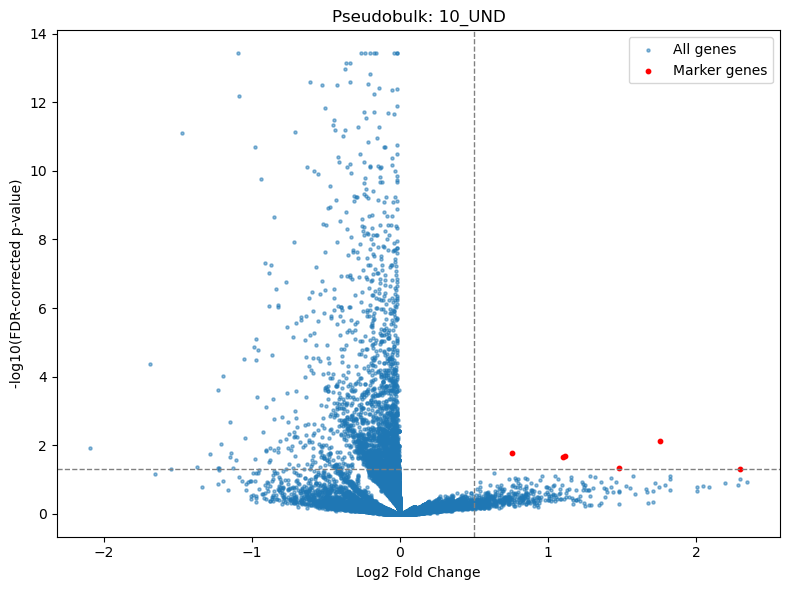

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


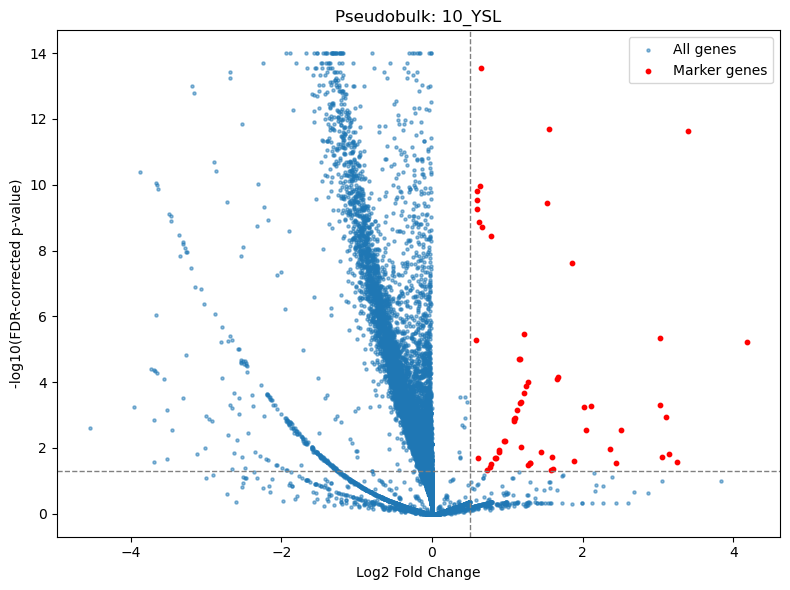

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


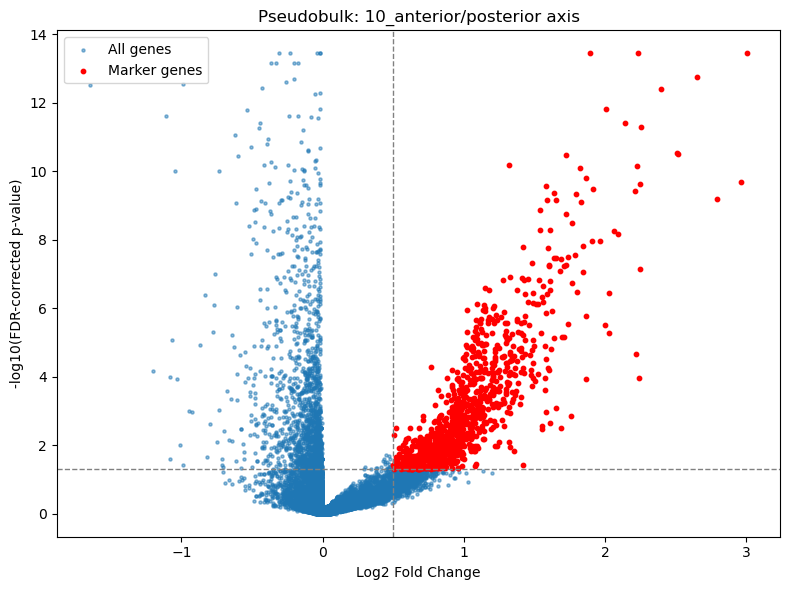

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


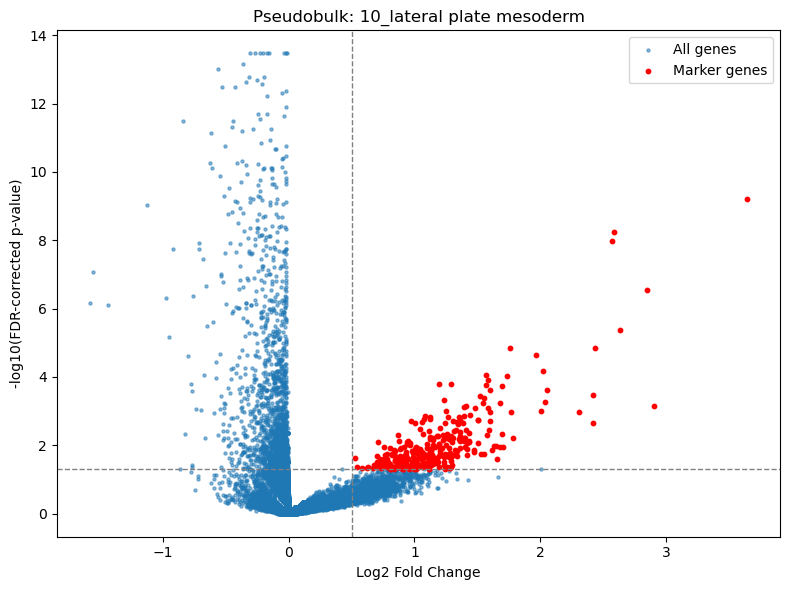

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


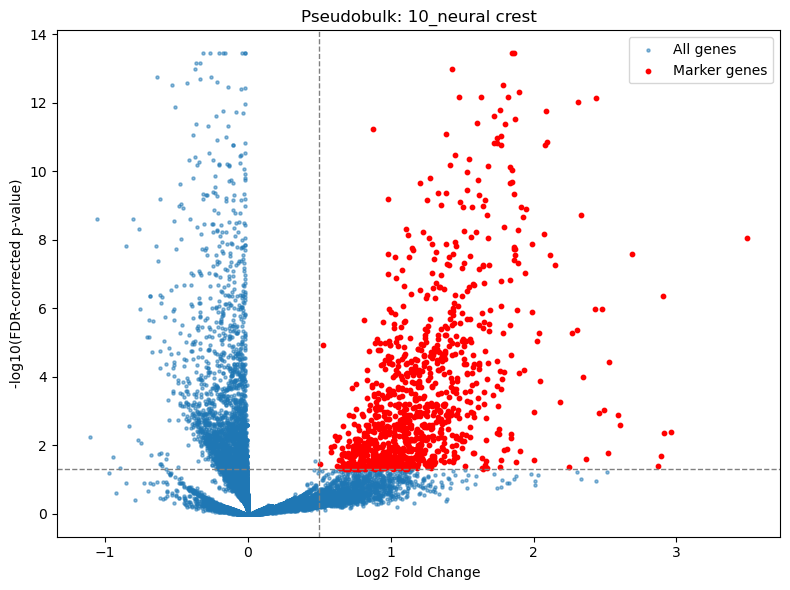

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


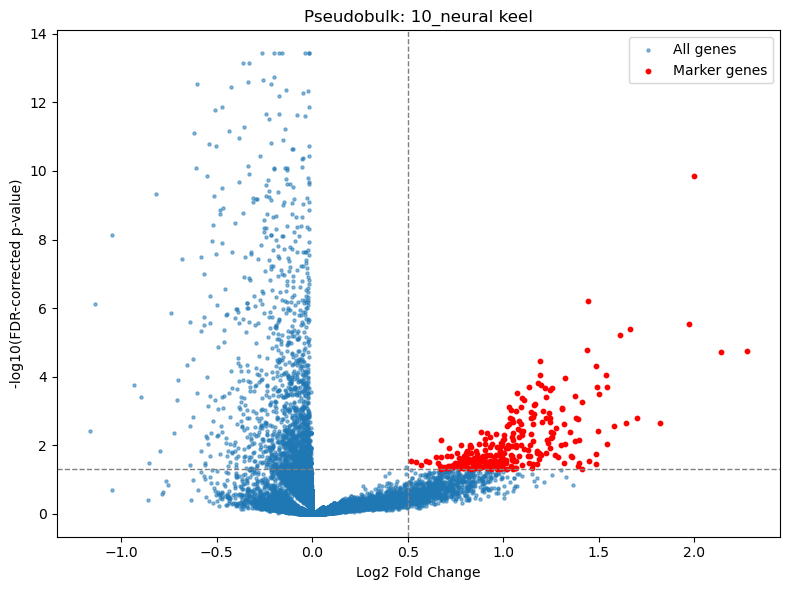

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


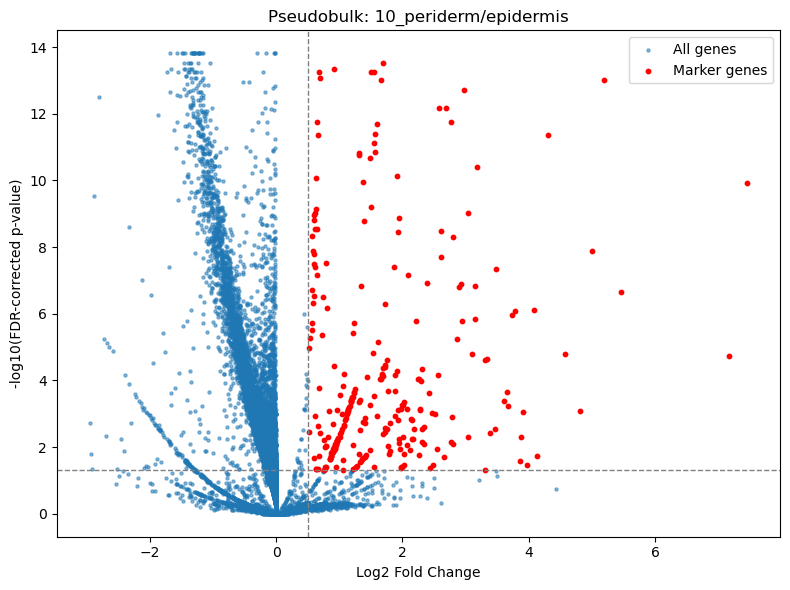

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


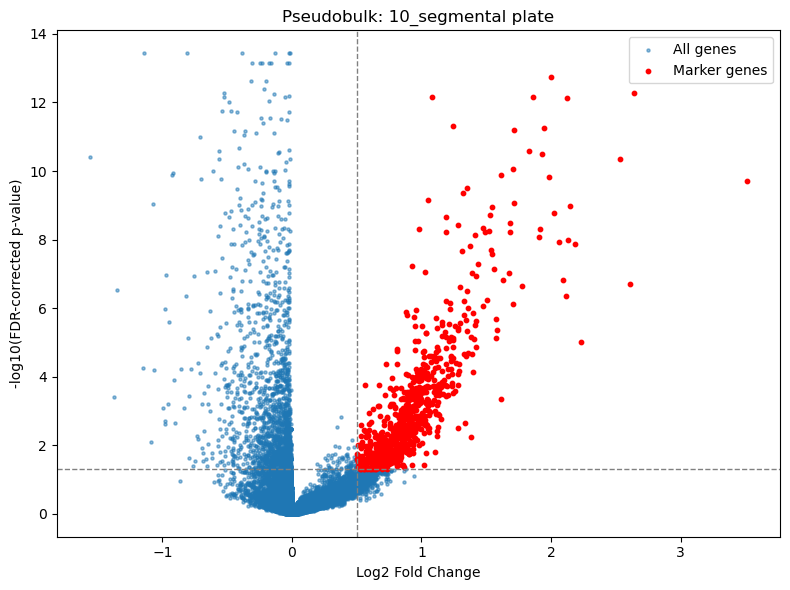

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


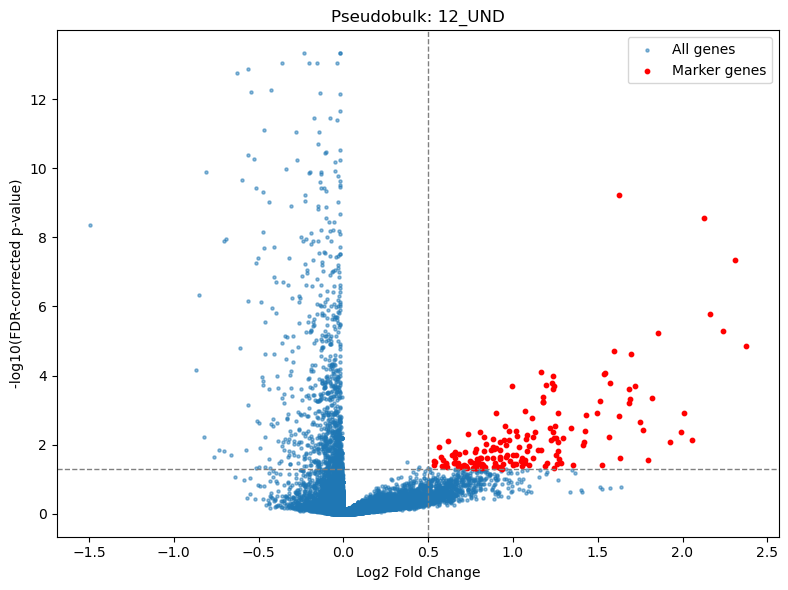

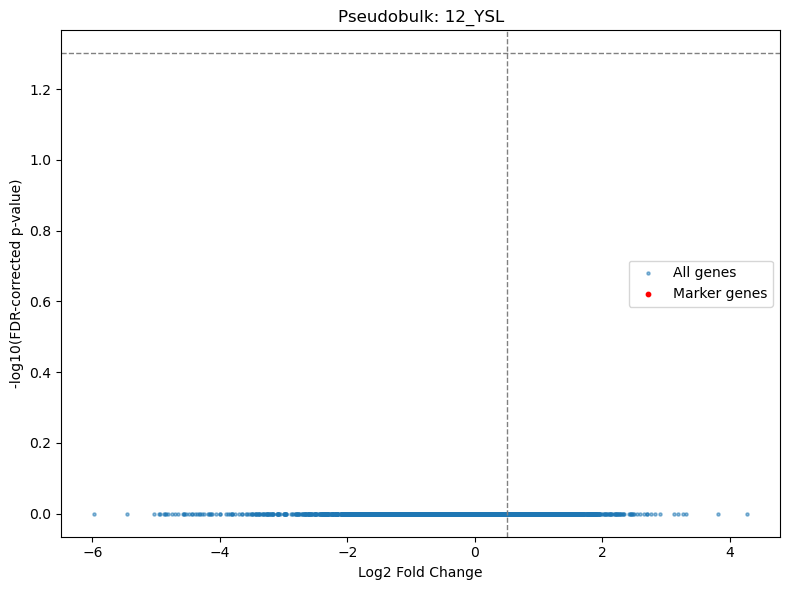

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


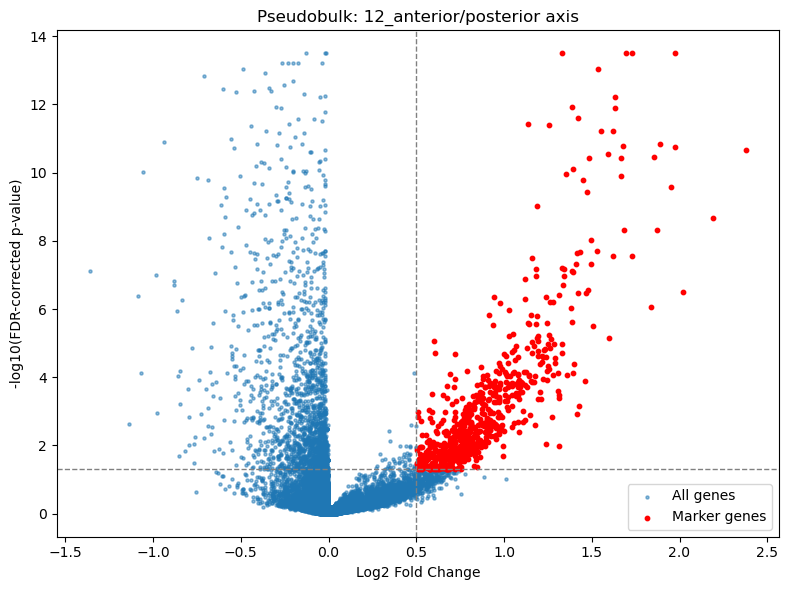

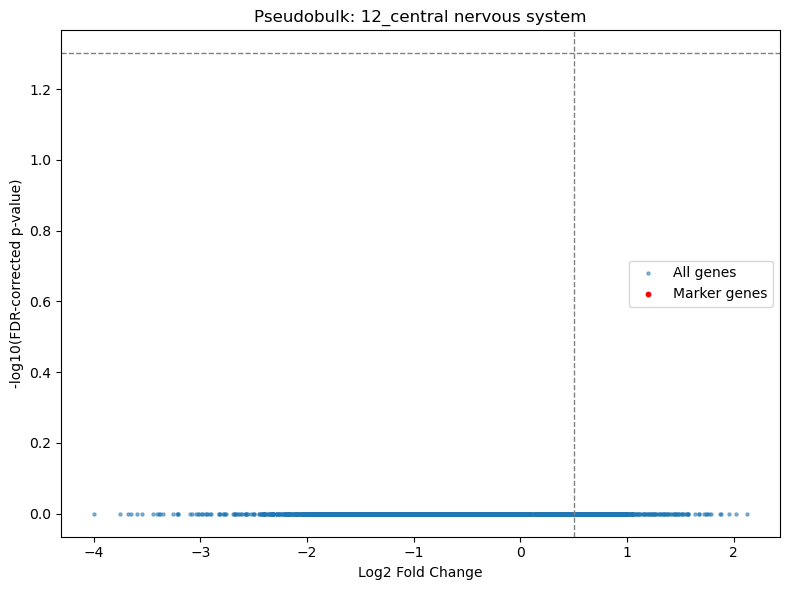

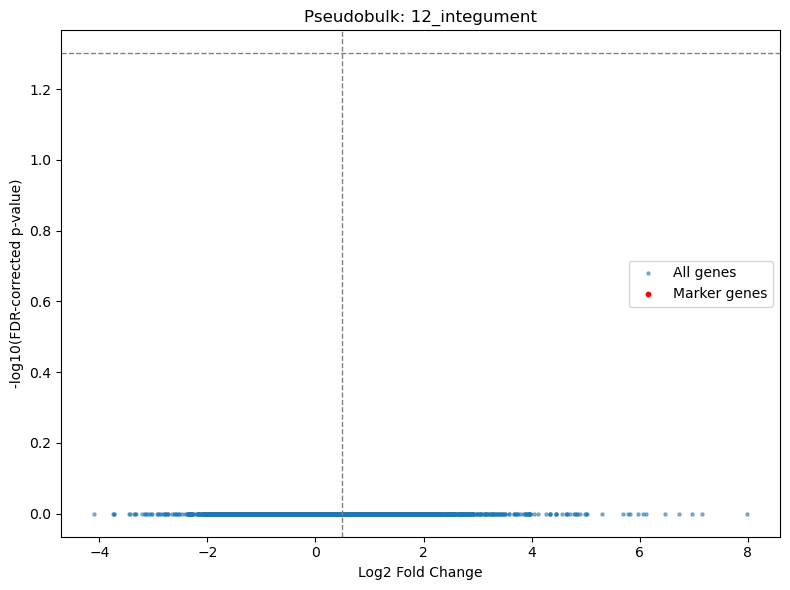

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


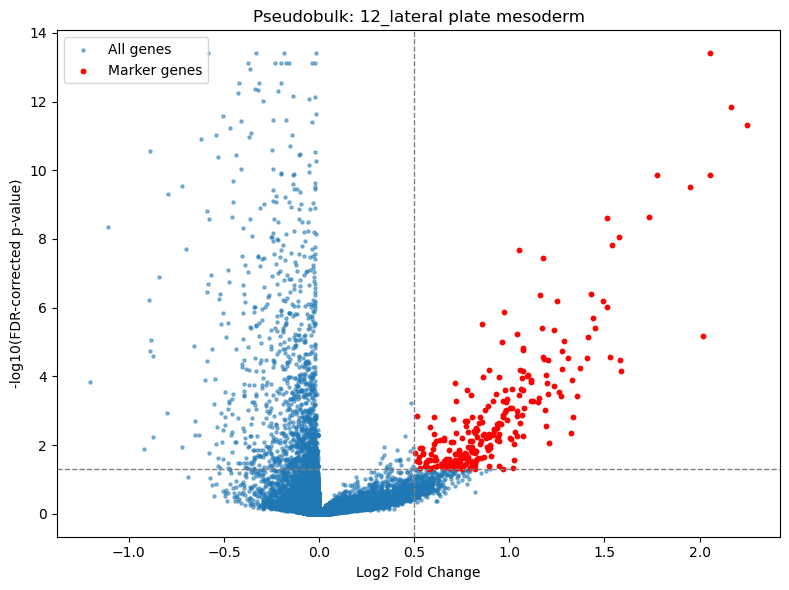

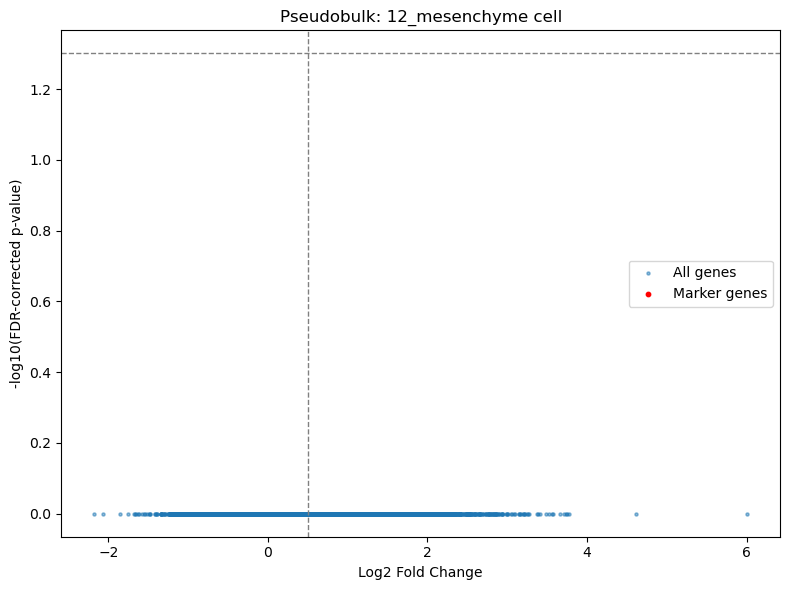

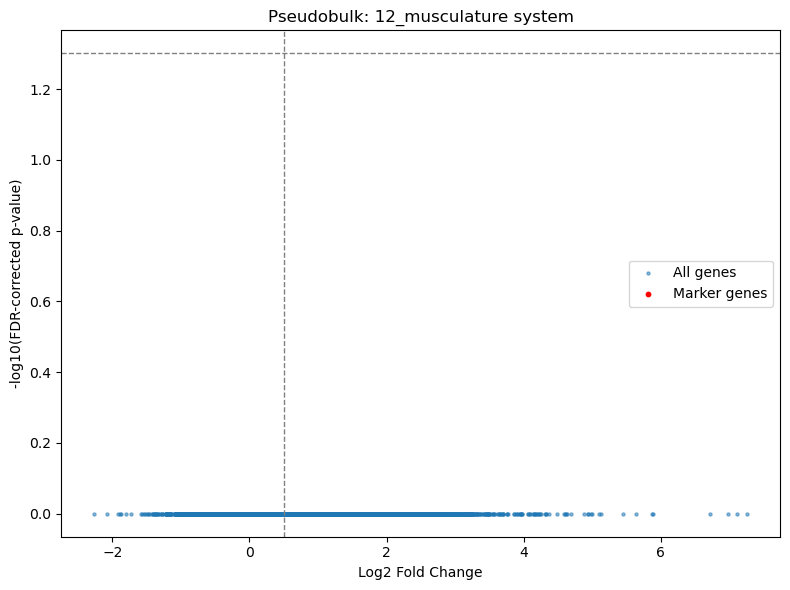

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


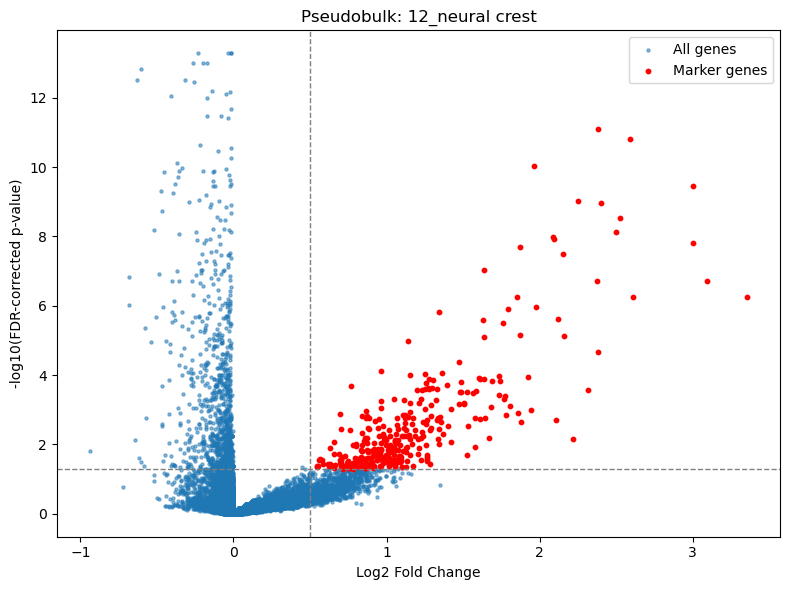

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


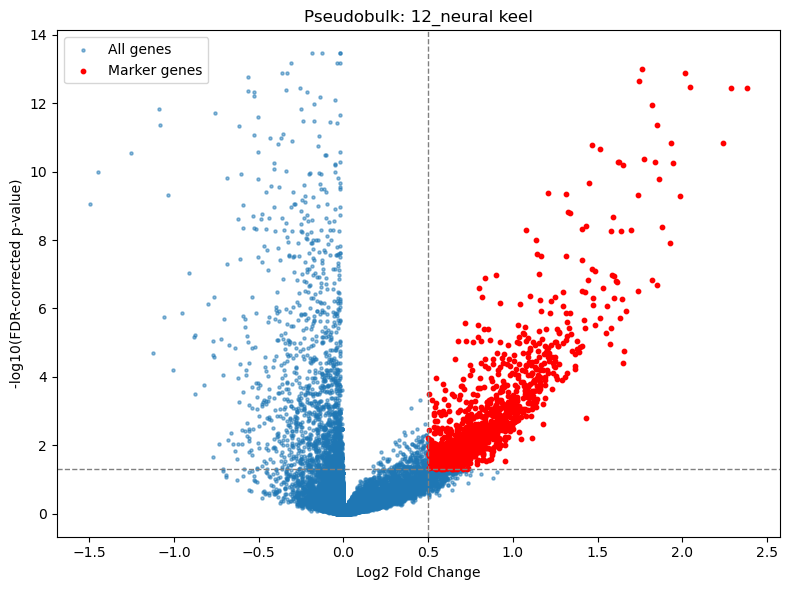

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


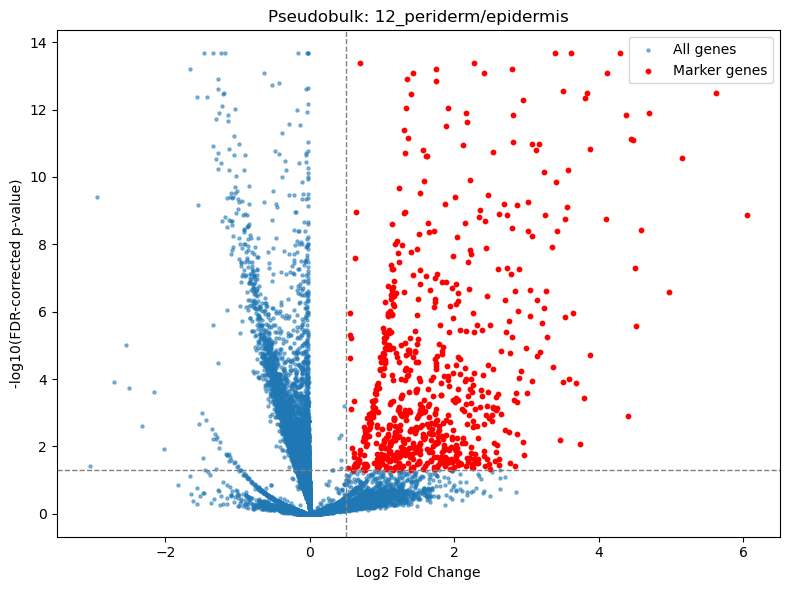

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


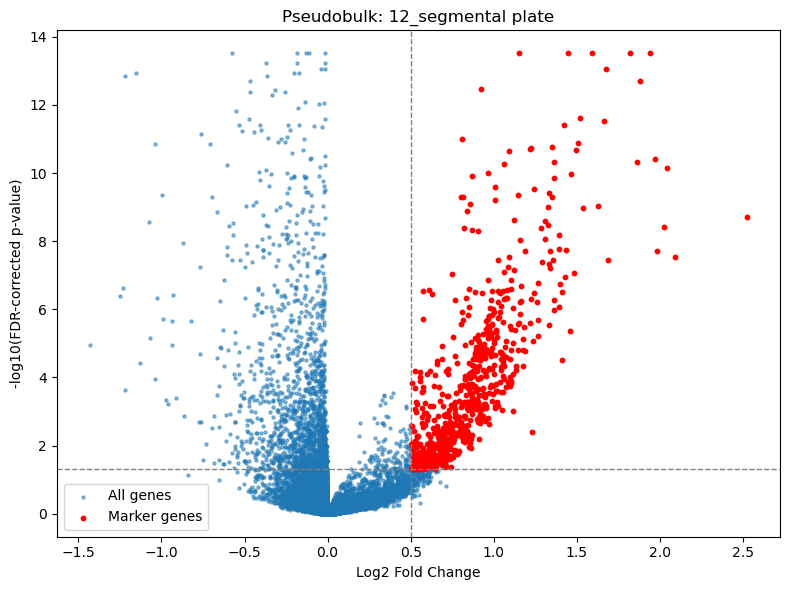

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


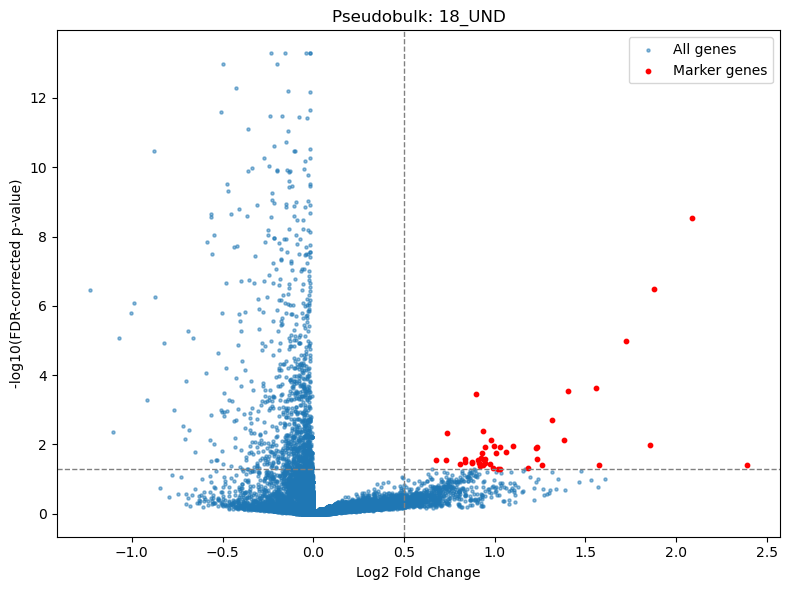

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


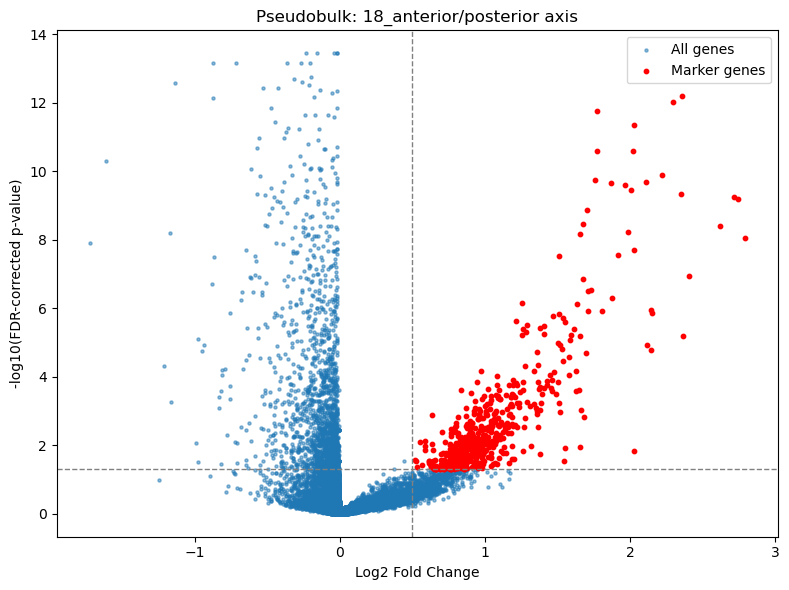

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


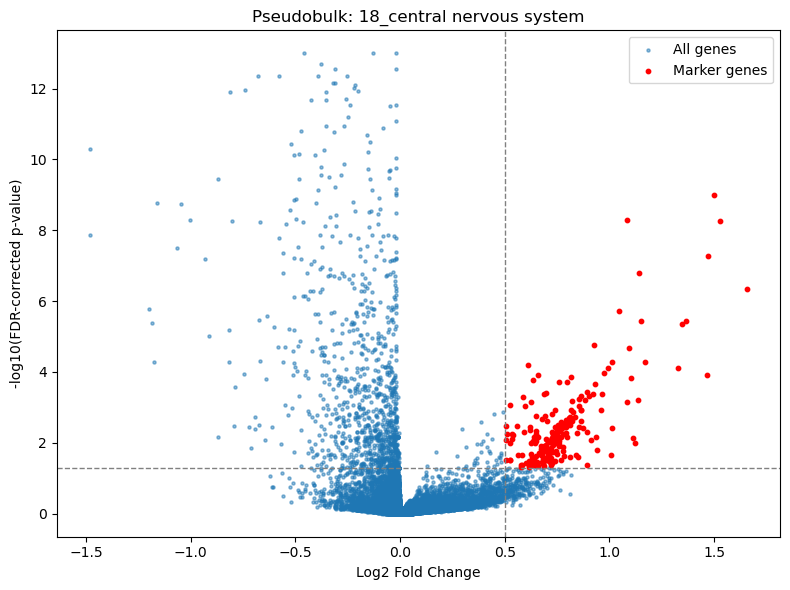

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


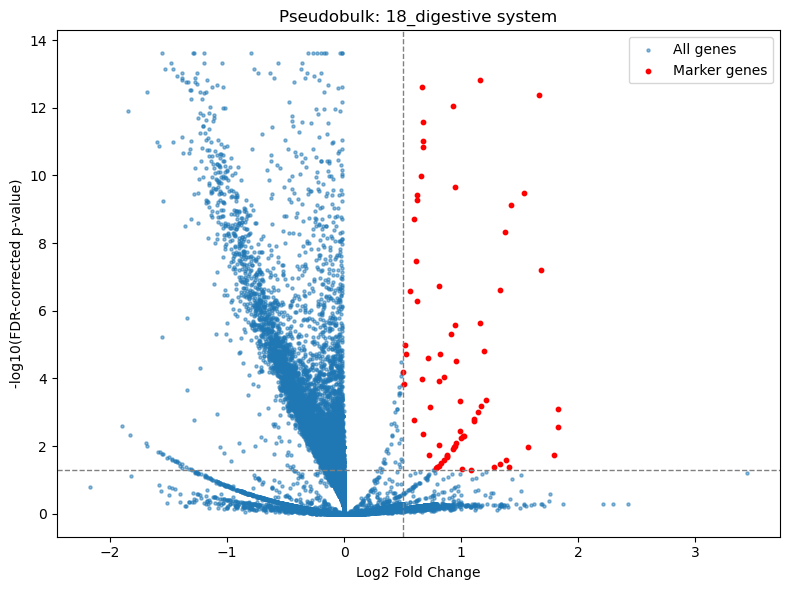

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


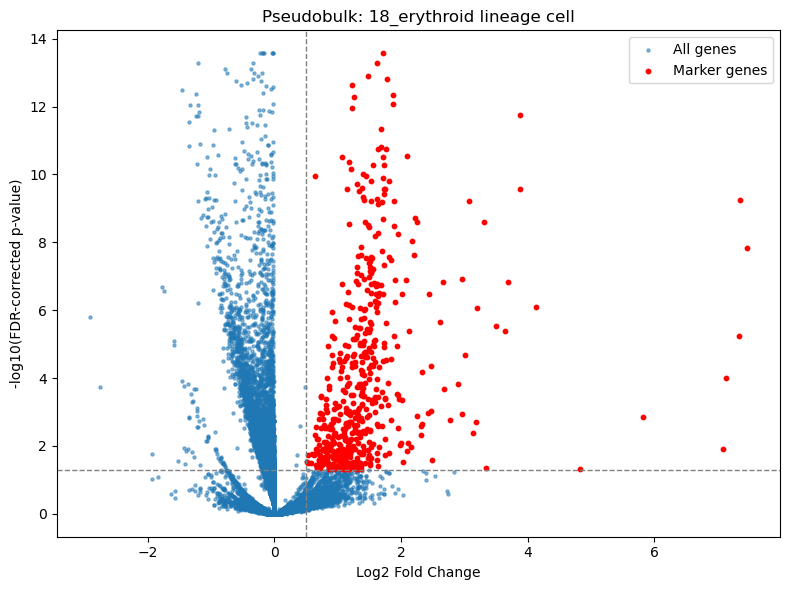

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


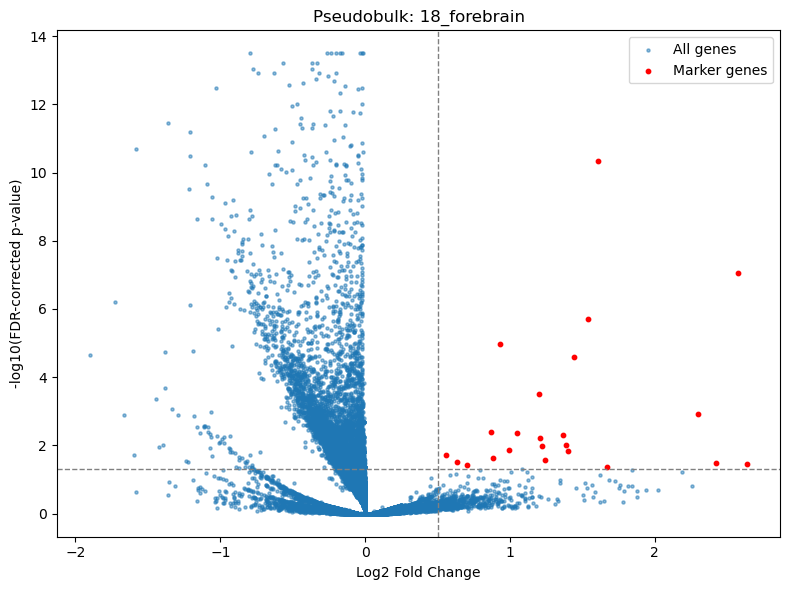

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


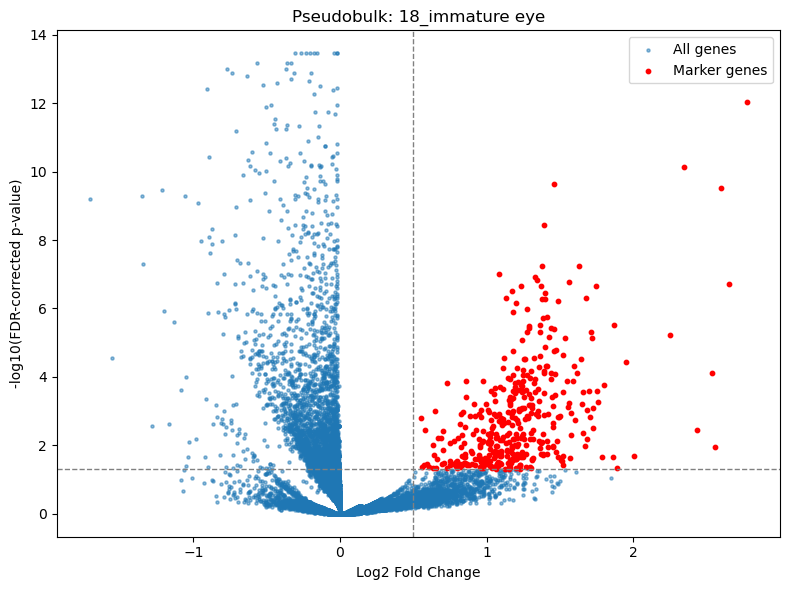

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


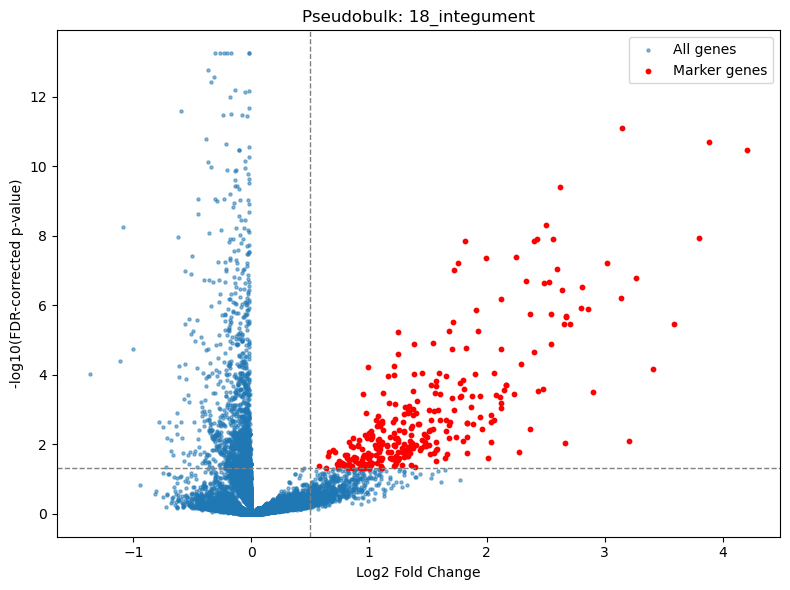

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


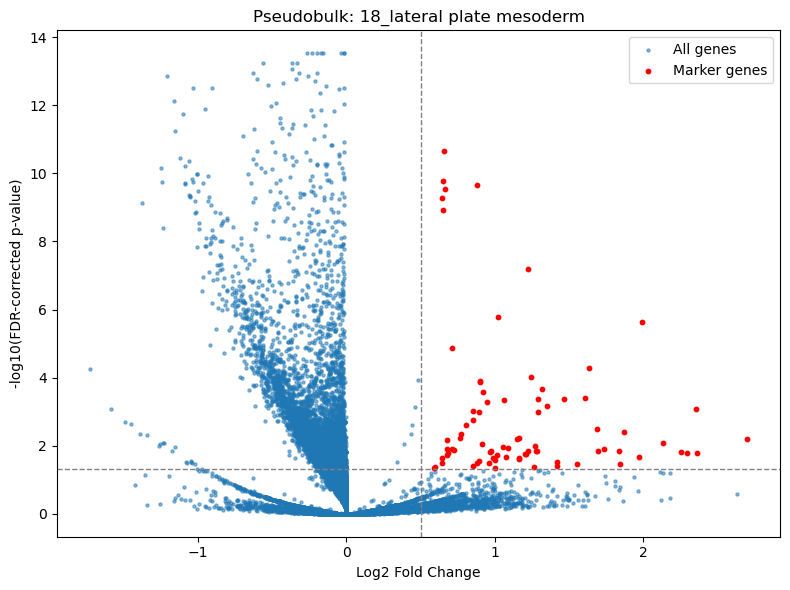

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


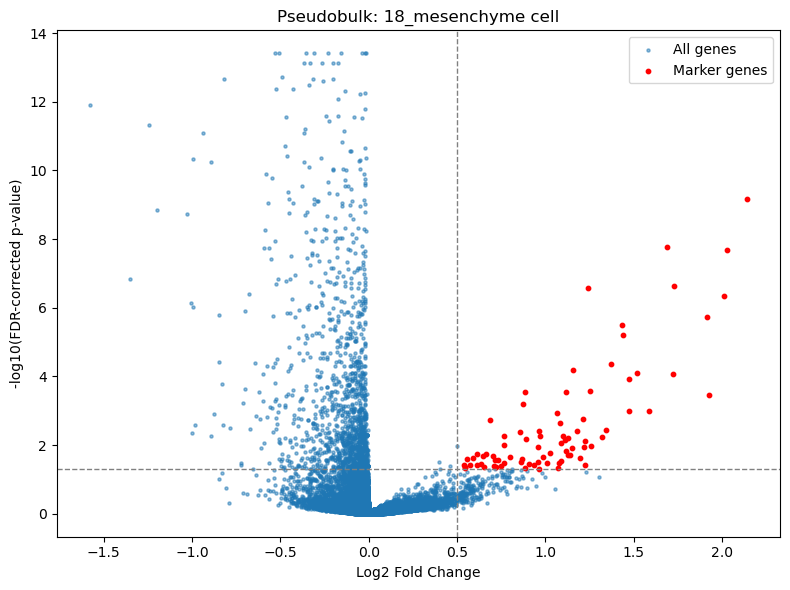

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


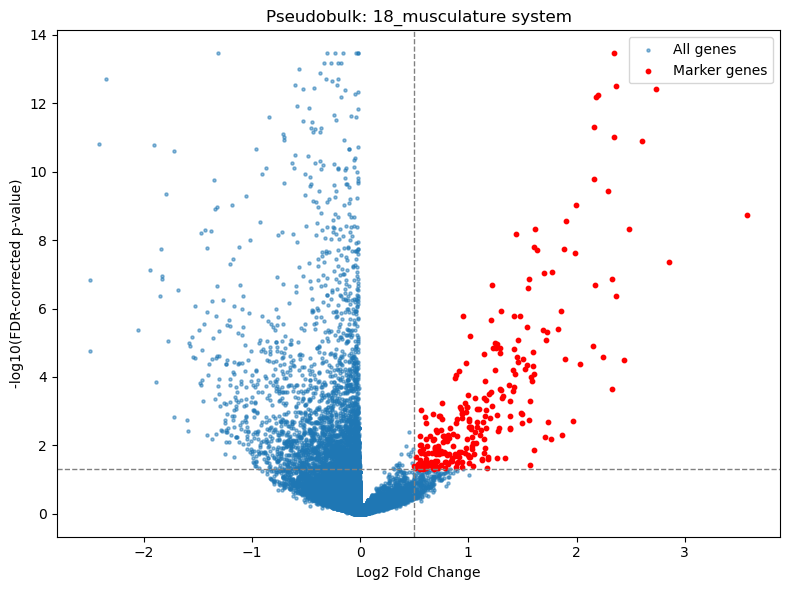

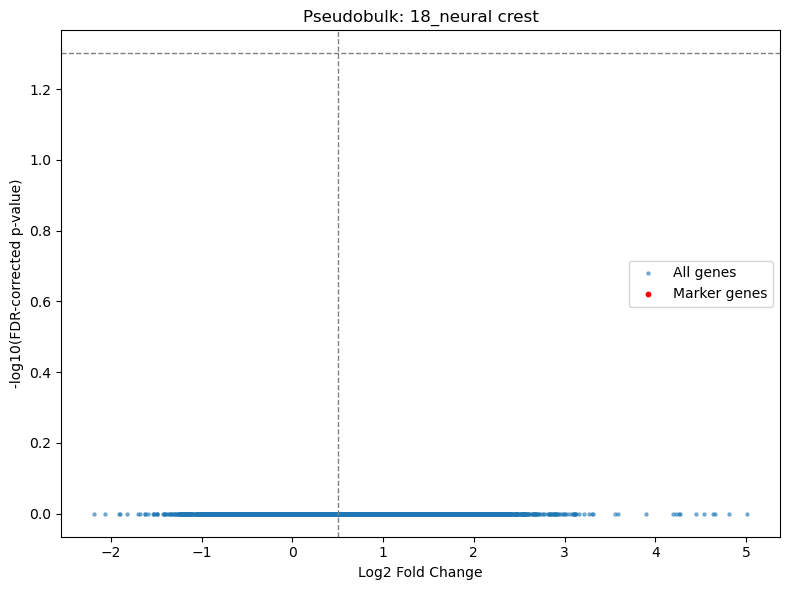

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


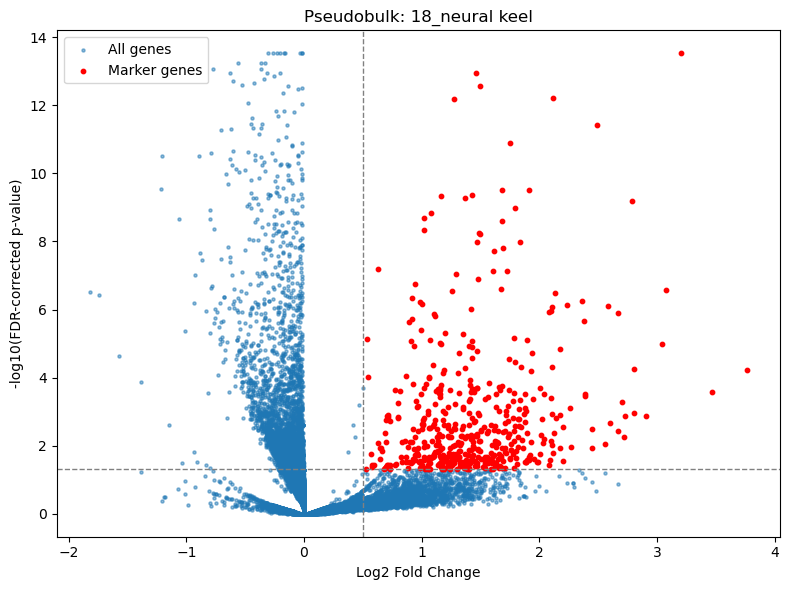

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


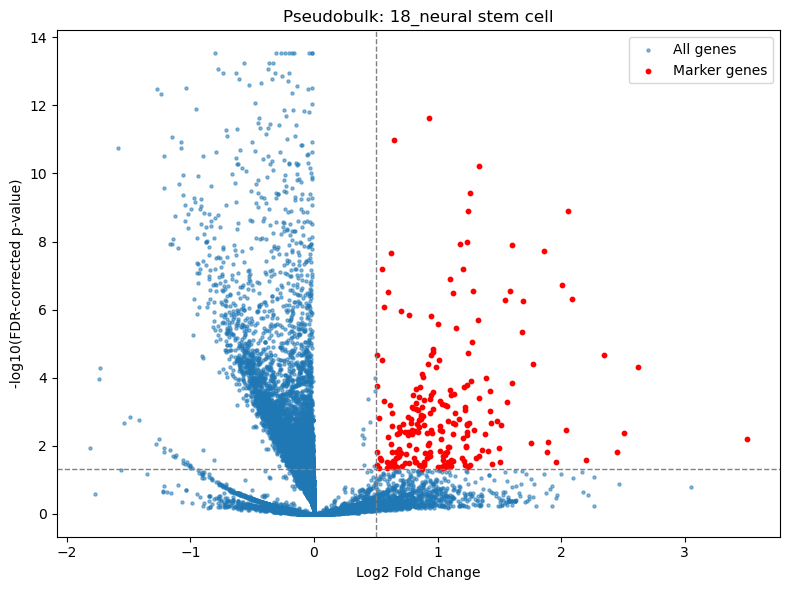

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


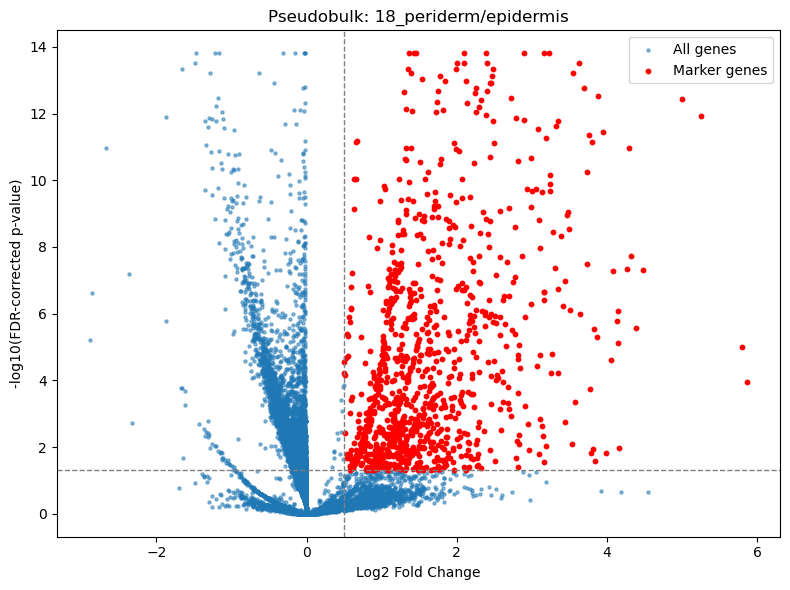

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


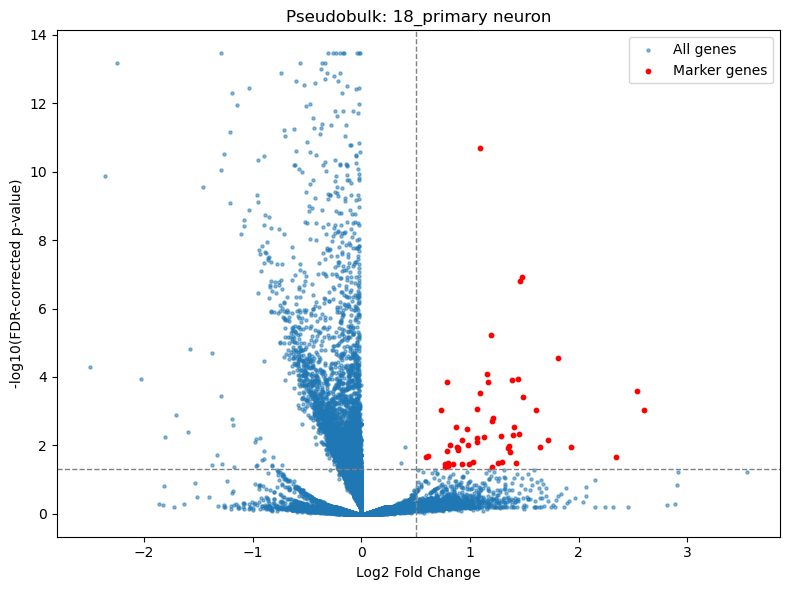

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


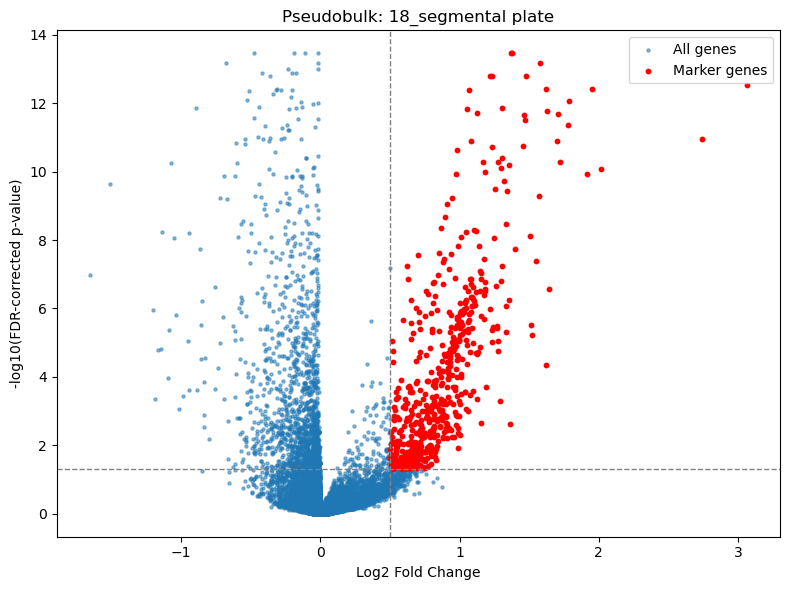

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


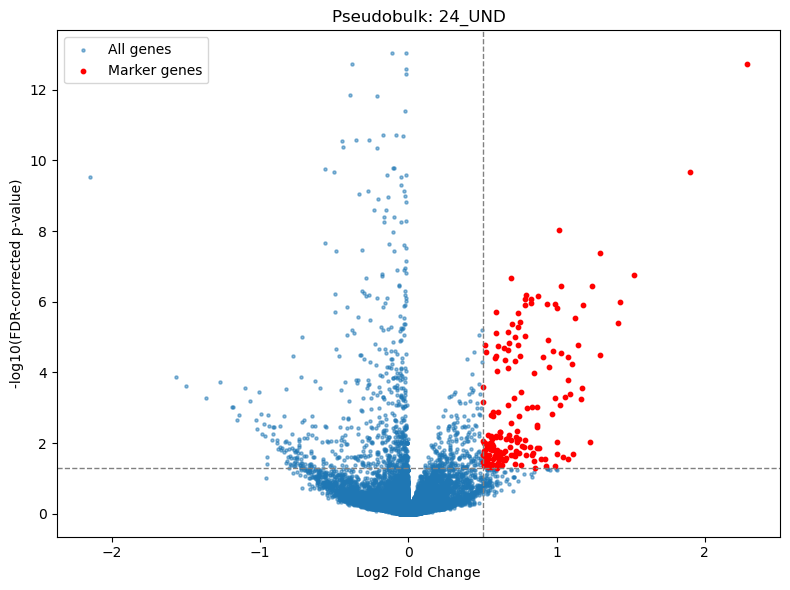

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


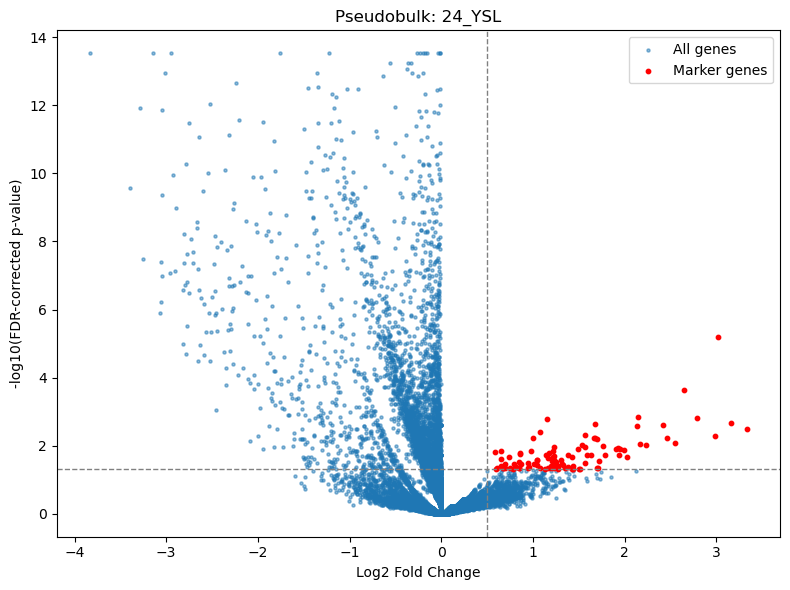

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


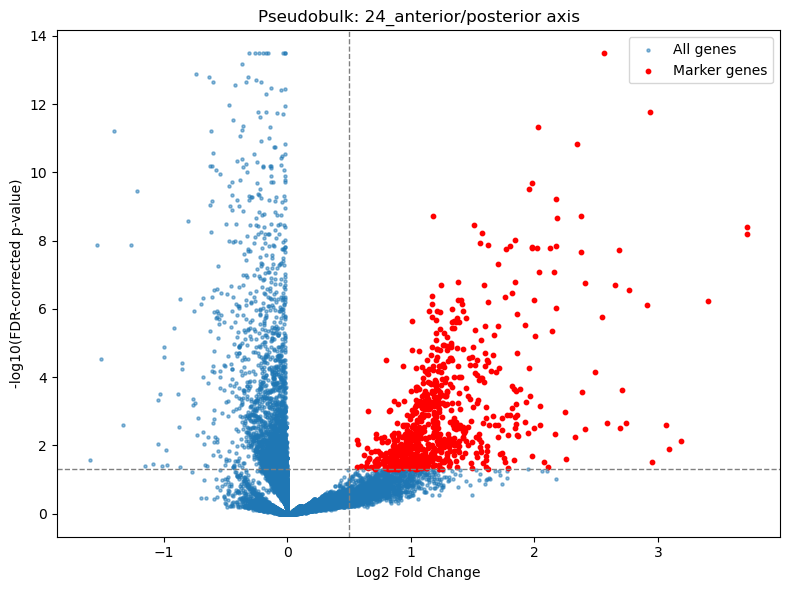

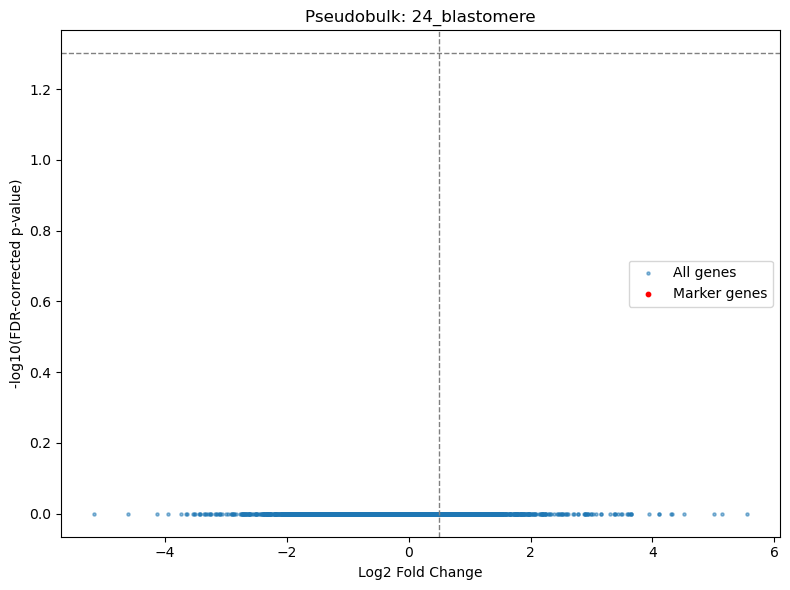

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


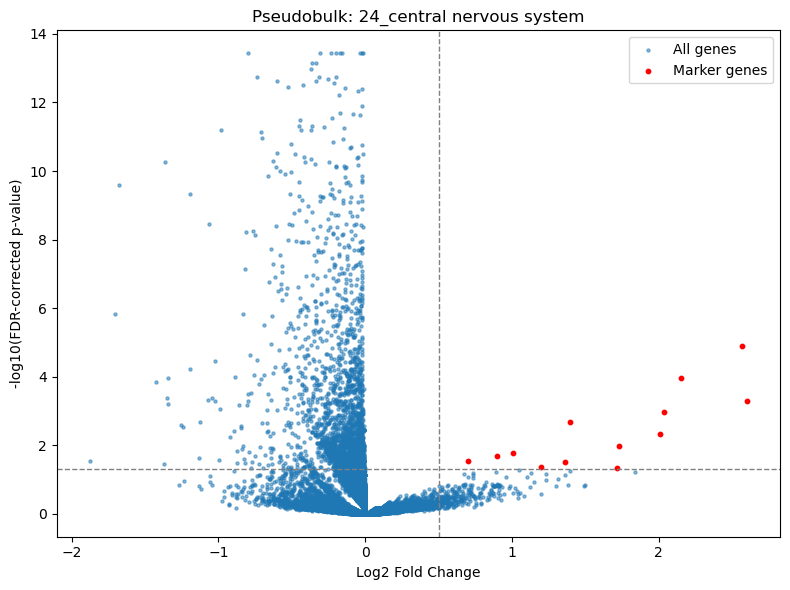

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


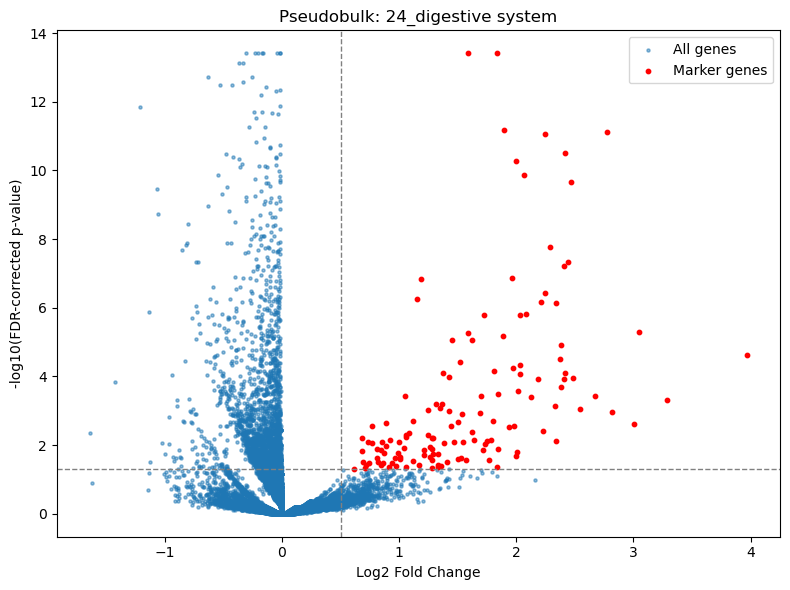

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


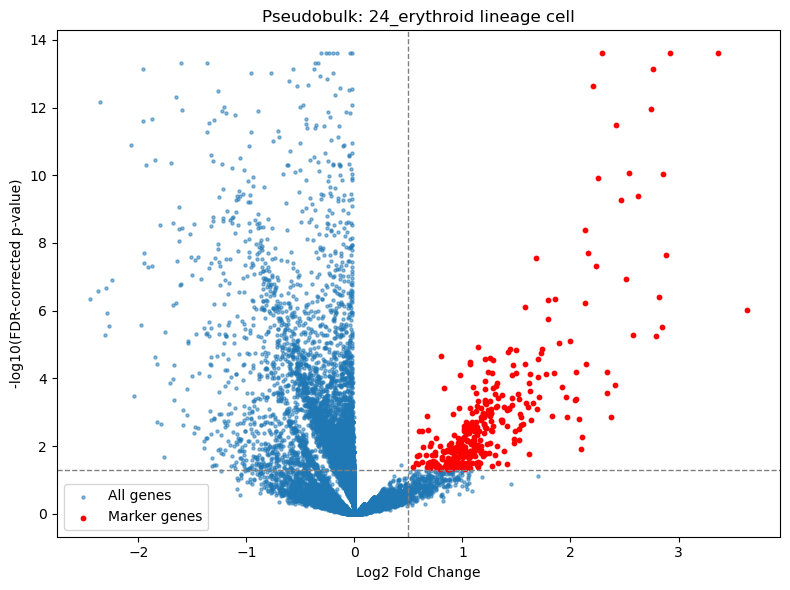

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


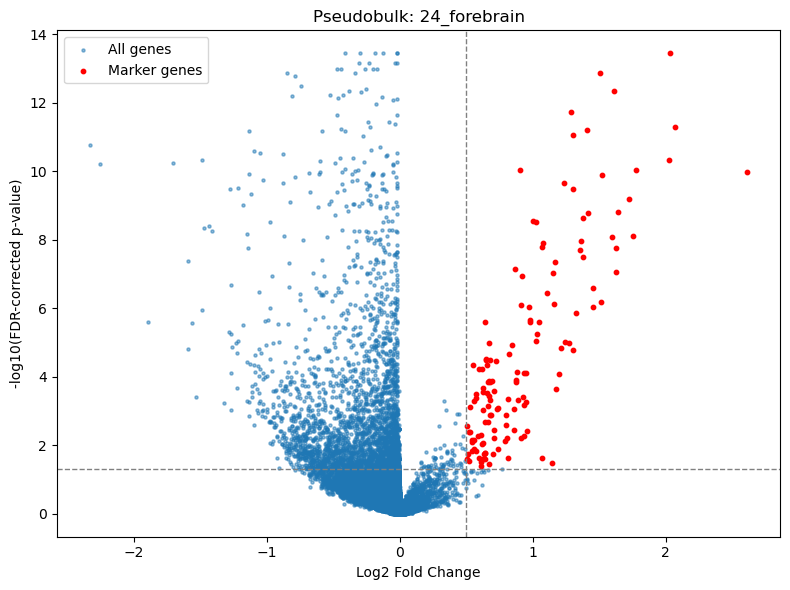

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


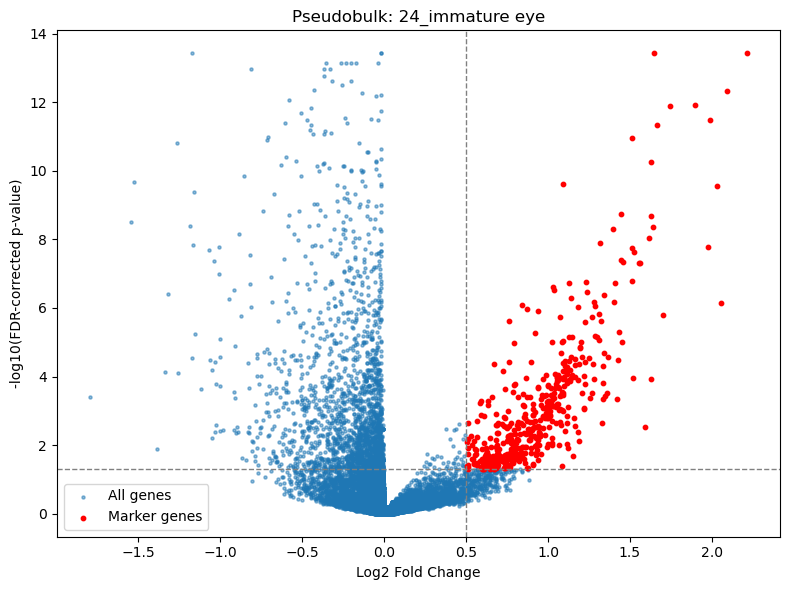

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


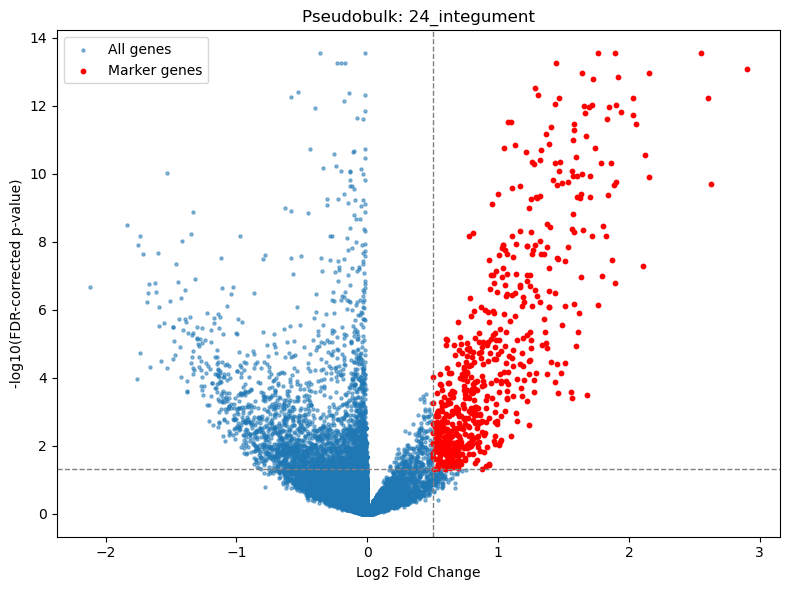

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


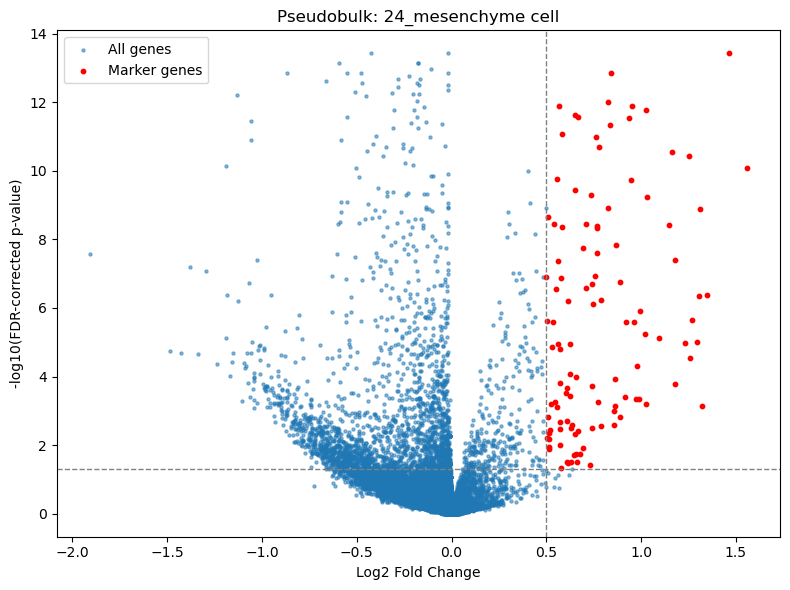

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


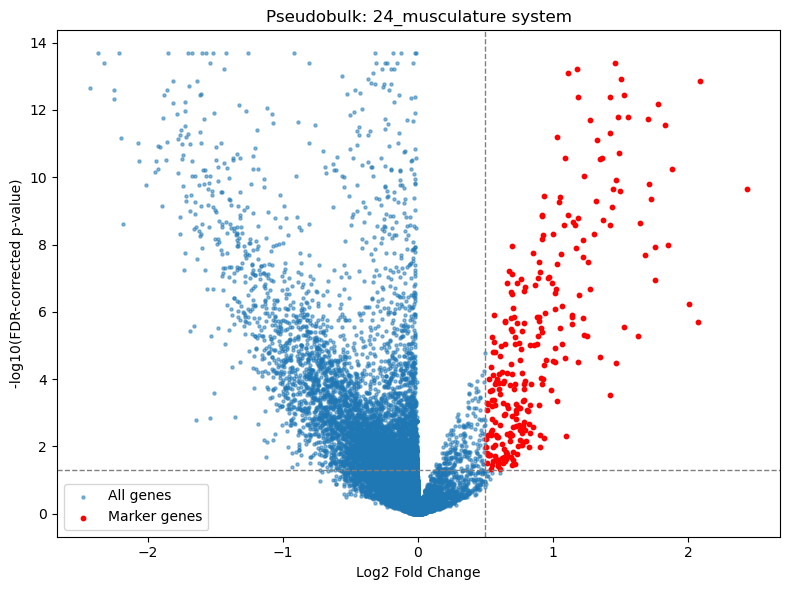

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


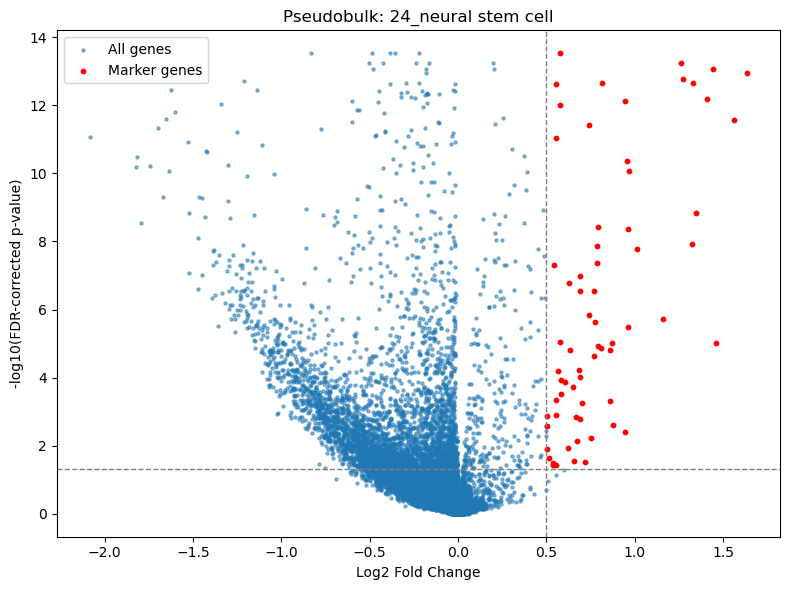

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


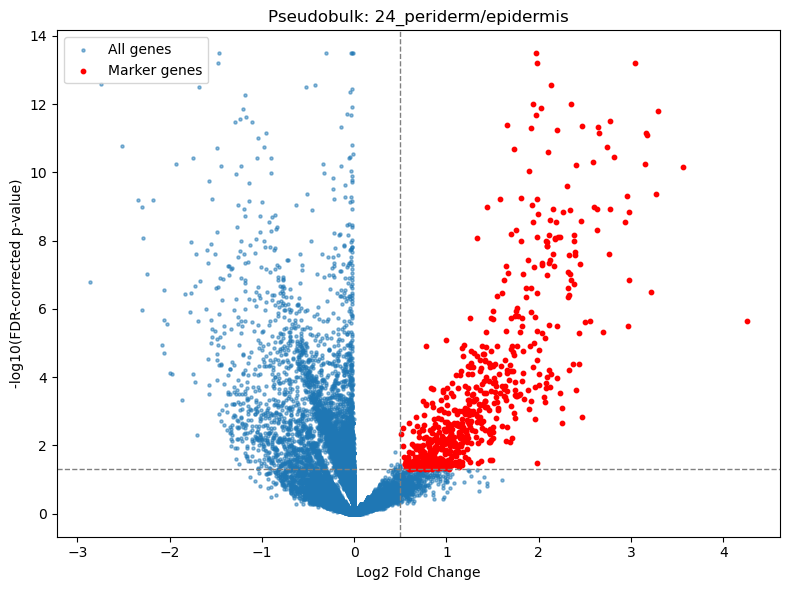

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


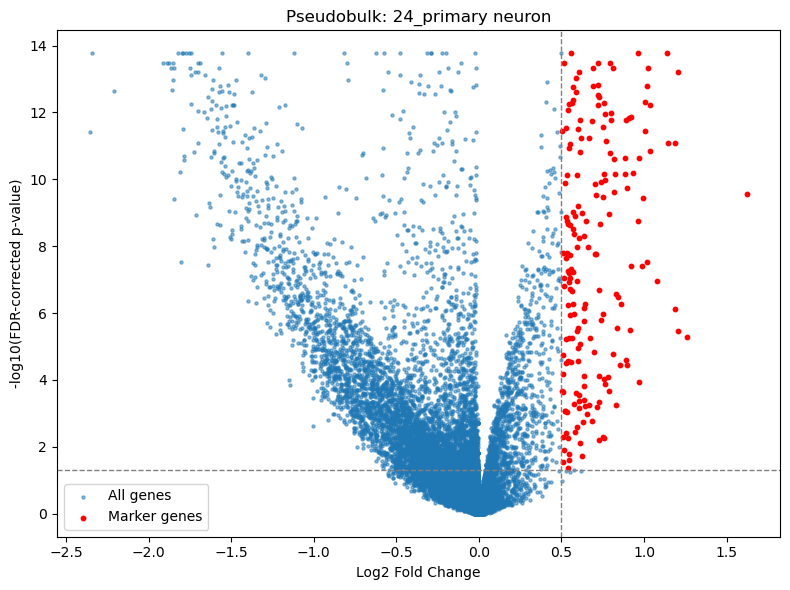

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


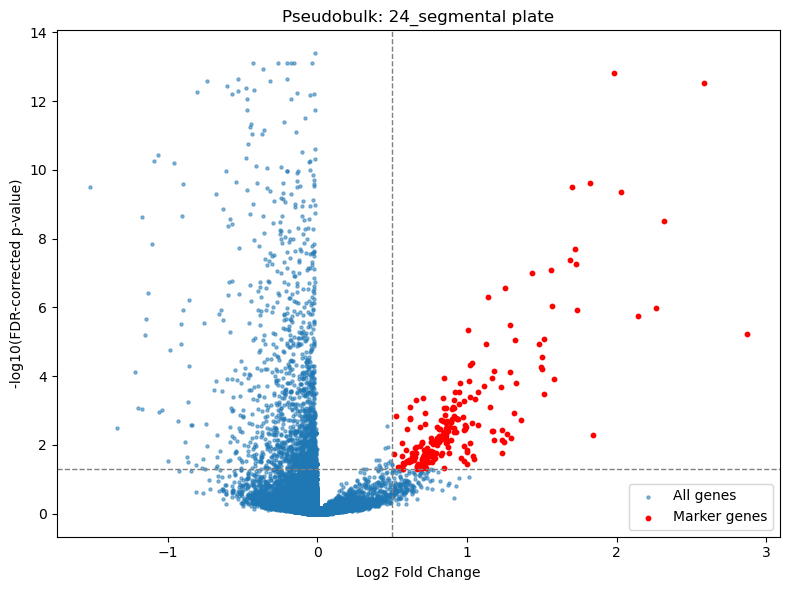

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


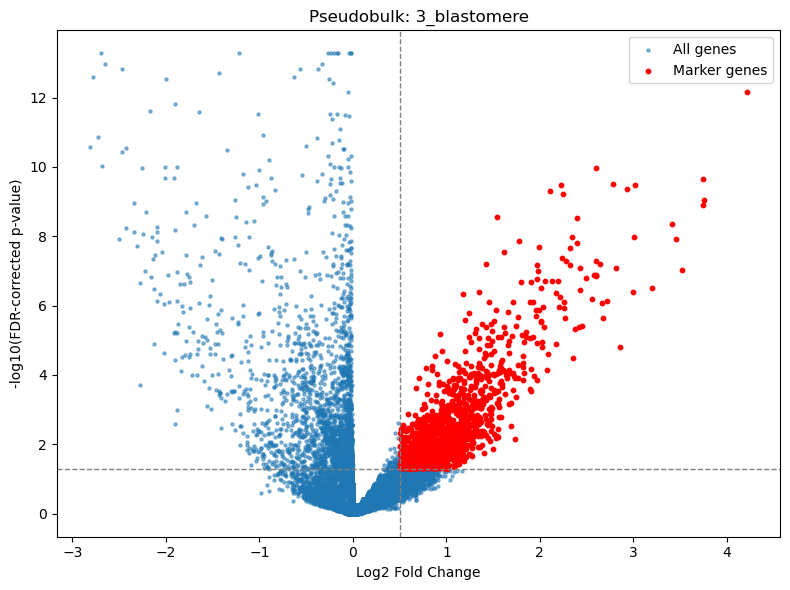

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


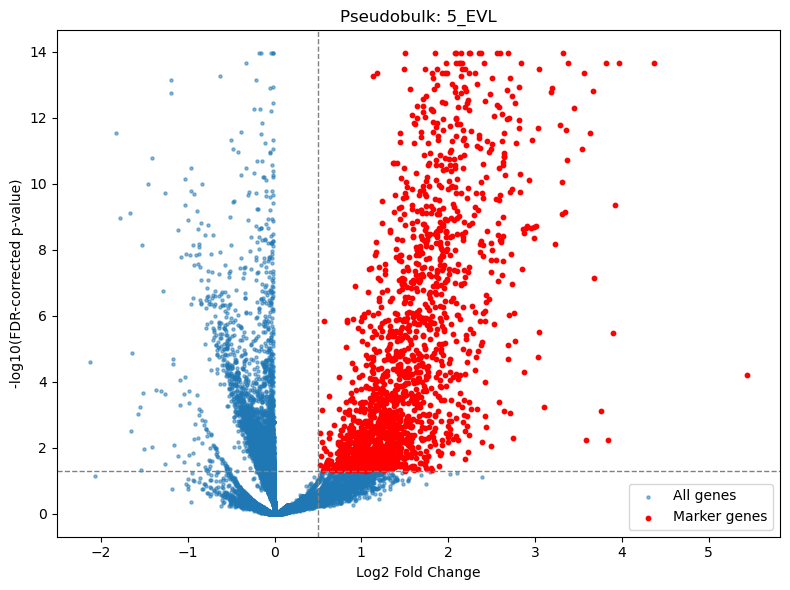

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")


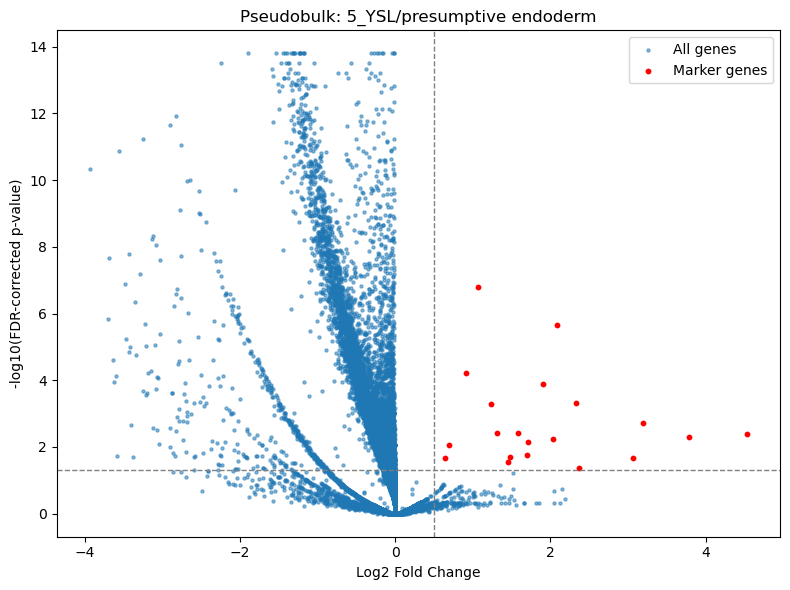

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


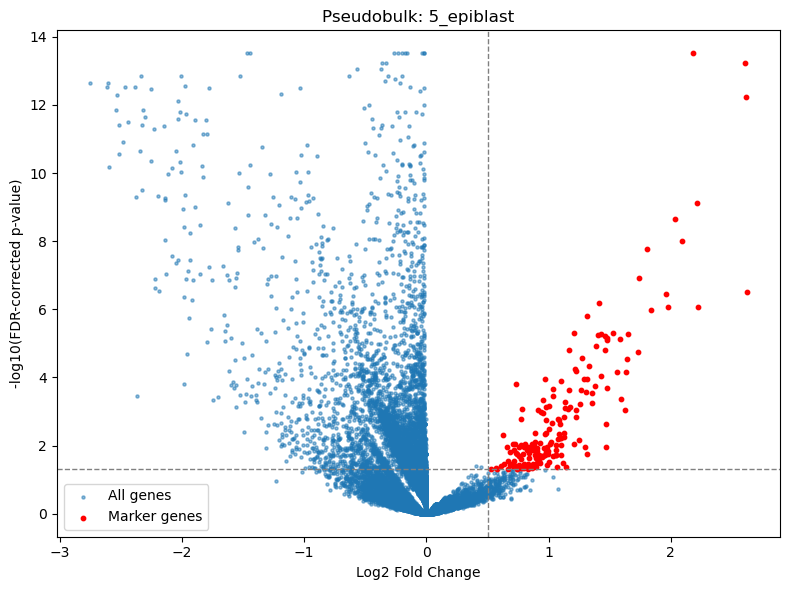

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


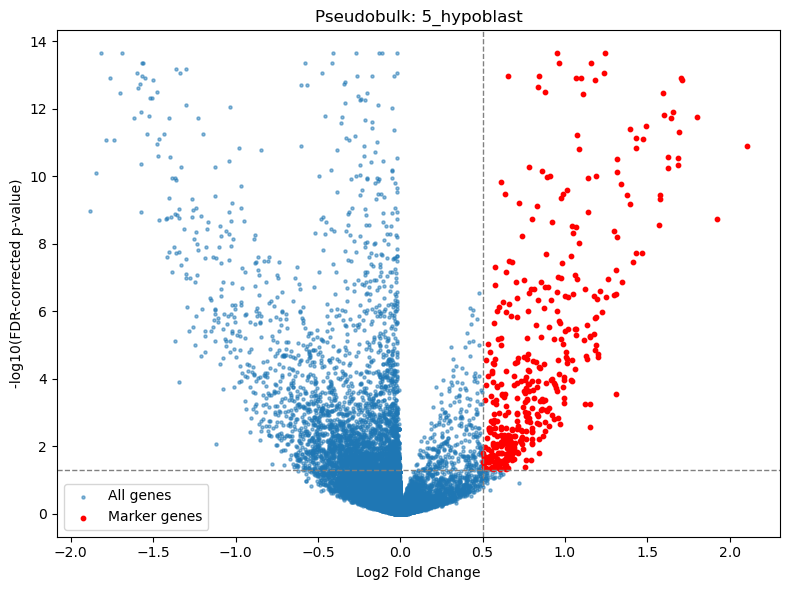

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


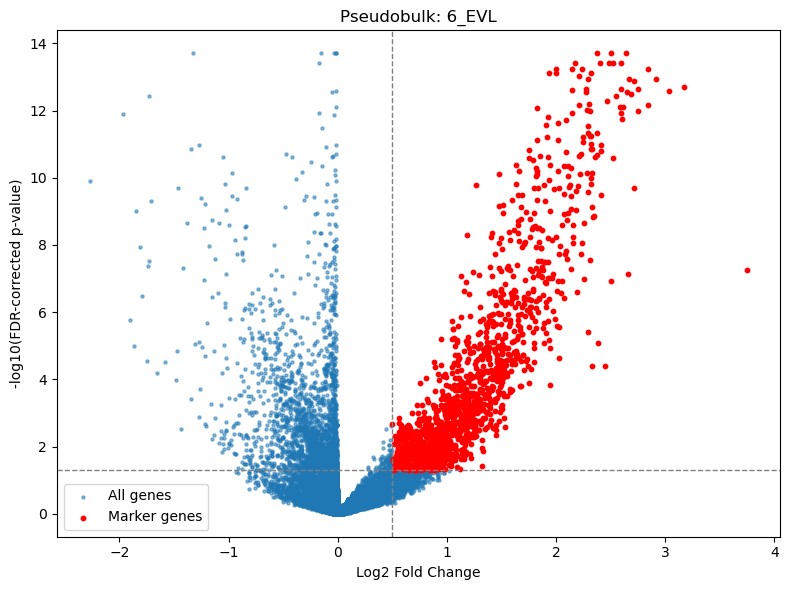

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


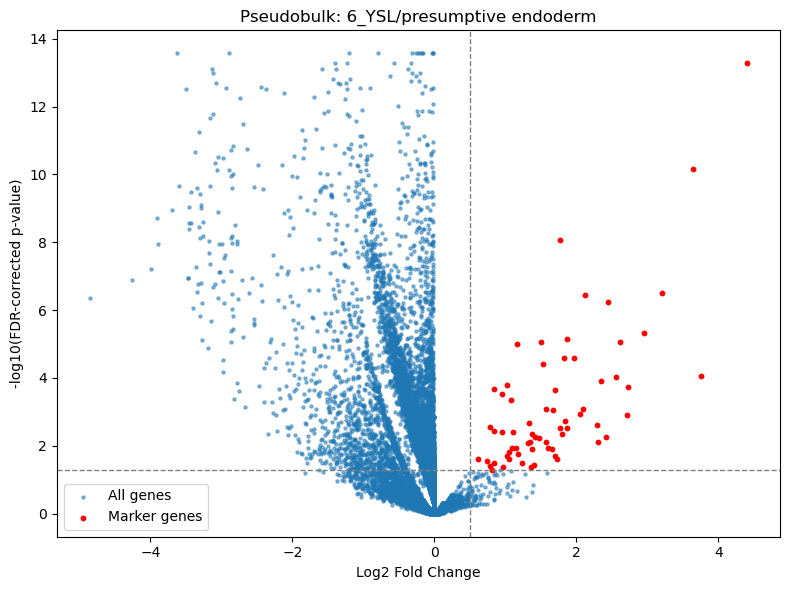

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


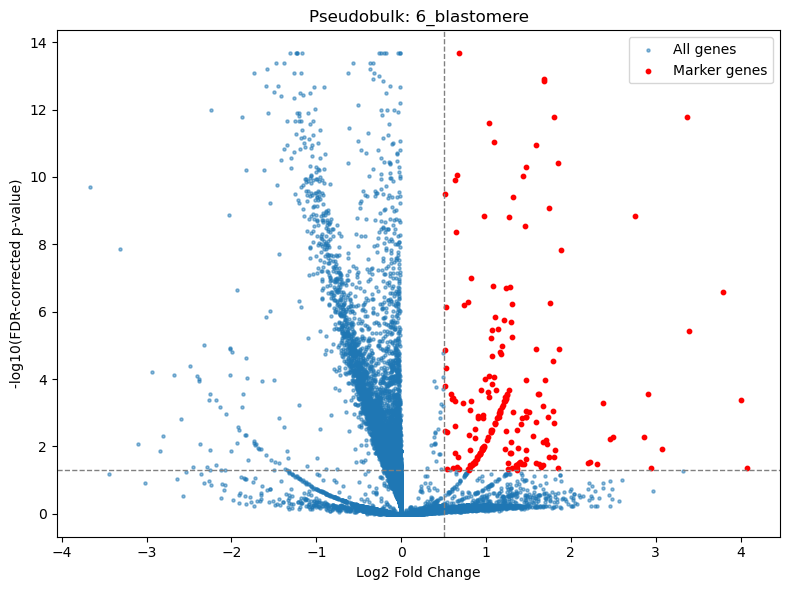

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


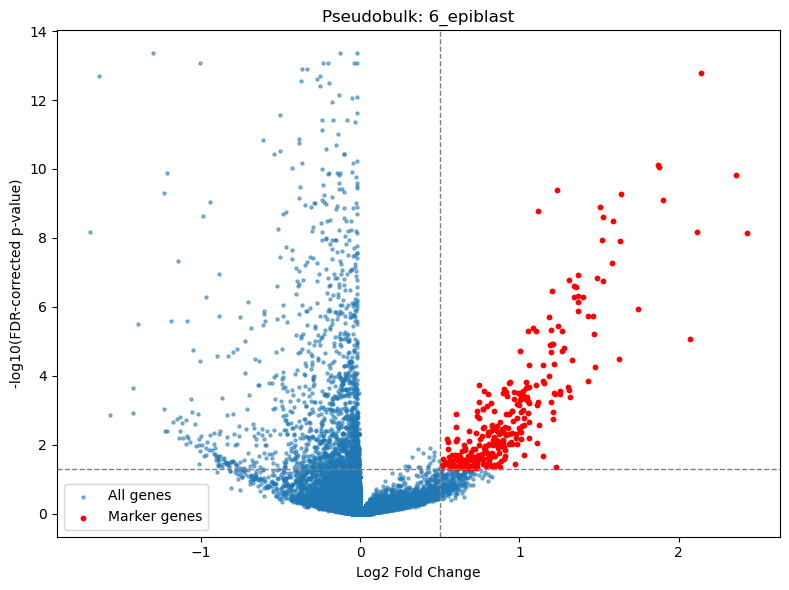

/tmp/ipykernel_3381107/1031201646.py:34: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
/tmp/ipykernel_3381107/1031201646.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')


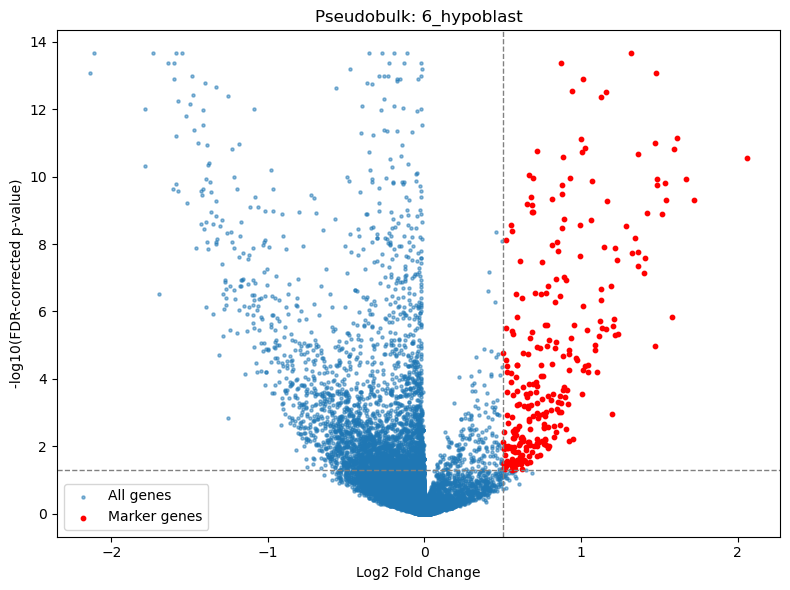

In [202]:
import matplotlib.pyplot as plt
import numpy as np

def plot_volcano_plots(mean_df, std_df, sample_sizes, marker_dict, title_prefix="Pseudobulk"):
    genes = mean_df.index
    pseudobulks = mean_df.columns

    for target_pb in pseudobulks:
        other_pbs = [pb for pb in pseudobulks if pb != target_pb]

        mu1 = mean_df[target_pb]
        sd1 = std_df[target_pb]
        n1 = sample_sizes[target_pb]

        mu2 = mean_df[other_pbs].mean(axis=1)
        sd2 = std_df[other_pbs].mean(axis=1)
        n2 = sample_sizes[other_pbs].mean()

        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        from scipy.stats import norm
        from statsmodels.stats.multitest import multipletests

        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")

        log_fc = mu1 - mu2

        plt.figure(figsize=(8, 6))
        plt.scatter(log_fc, -np.log10(pvals_corrected), s=5, alpha=0.5, label="All genes")
        
        # Highlight marker genes
        marker_genes = marker_dict[target_pb]
        marker_mask = mean_df.index.isin(marker_genes)
        plt.scatter(log_fc[marker_mask], -np.log10(pvals_corrected[marker_mask]), color='red', s=10, label='Marker genes')

        plt.title(f"{title_prefix}: {target_pb}")
        plt.xlabel("Log2 Fold Change")
        plt.ylabel("-log10(FDR-corrected p-value)")
        plt.axhline(-np.log10(0.05), color='grey', linestyle='--', linewidth=1)
        plt.axvline(0.5, color='grey', linestyle='--', linewidth=1)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Call the volcano plot function for pseudobulks
plot_volcano_plots(rna_data_mean_pseudobulk_og, rna_data_std_pseudobulk_og, pseudobulk_counts, marker_genes_per_pseudobulk, title_prefix="Pseudobulk")

